In [1]:
from pathlib import Path
base = Path.cwd()
if "notebooks" in base.name:
    %cd ..
print(f"Running from path {Path.cwd()}")

/Users/peli/Projects/Repositories/DDM-NumEstPark
Running from path /Users/peli/Projects/Repositories/DDM-NumEstPark


In [2]:
import numpy as np
import pandas as pd
import joblib
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import graphviz
import seaborn as sns
from datetime import datetime
from src.model import build_subject_model, build_hierarchical, build_hierarchical_lnlik
from src.utils import get_paths

In [3]:
# Setup
az.style.use("arviz-docgrid") # set arviz style
# setup main vars of interest
# set plot output dir
model_name = "model_1"
plot_dir = Path("plots") / model_name
plot_dir.mkdir(exist_ok=True)
# save plot function

In [4]:
def get_sub_paths():
    """
    Return a list of all file paths of csv data
    """
    dir = "data"
    base = Path.cwd()
    data_dir = base / dir
    data_files = list(data_dir.glob('*.csv'))
    print(f"data_files {data_files}")
    return data_files

def get_subject_data():
    files = get_sub_paths()
    file = files[0]
    df = pd.read_csv(file)
    print(df.head(5))
    subject_df = df[df["S_ID"] == "S_00"]

    x_stim = subject_df["Presented_numerosity"]
    y_obs = subject_df["Estimated_numerosity"]

    print(f"Length n_stim {len(x_stim)}")
    print(f"n_stim: {x_stim.value_counts().sort_index()}")
    print(f"Length y_obs {len(y_obs)}")
    print(f"y_obs: {y_obs.value_counts().sort_index()}")
    return x_stim, y_obs

def get_all_data(
        subset_prop: float | None = None
):
    path = get_paths("dataset", "*")

    df = pd.read_csv(path)
    

    if subset_prop:
        assert 0 < subset_prop < 1
        np.random.seed(89)
        # Get unique subject IDs
        unique_subjects = df["S_ID"].unique()
        # Randomly sample ~20% of subjects
        n_subset = max(1, int(subset_prop * len(unique_subjects)))  # at least 1 subject
        sampled_subjects = np.random.choice(
            unique_subjects, 
            size=n_subset, 
            replace=False
        )
        # Filter dataframe to only those subjects
        df = df[df["S_ID"].isin(sampled_subjects)].reset_index(drop=True)

    X = df
    

    return X



In [5]:
# Load data
X = get_all_data()

# Encode hallucination group as Categorical (trial-level, but will extract per subject)
X["s_param_ph"] = X["s_param_ph"].replace({"1mh": "3mhch"})
order = ['0nh', '3mhch']
X["s_param_ph"] = pd.Categorical(X["s_param_ph"], categories=order, ordered=True)

# 1. Count UNIQUE subjects per hallucination group
subject_groups = X.drop_duplicates("S_ID")[["S_ID", "s_param_ph"]]
group_counts = subject_groups["s_param_ph"].value_counts().reindex(order, fill_value=0)
print("Number of subjects per hallucination group (s_param_ph):")
print(group_counts)
print()

# Number of unique participants
n_subjects_total = X["S_ID"].nunique()
print(f"Total number of unique subjects: {n_subjects_total}")

# Presented simtuli and estimated stimuli statistics
x_min = X["Presented_numerosity"].min()
x_max = X["Presented_numerosity"].max()
print(f"Presented numerosity Min: {x_min} Max: {x_max}")
y_min = X["Estimated_numerosity"].min()
y_max = X["Estimated_numerosity"].max()
y_mean = X["Estimated_numerosity"].mean()
print(f"Estimated numerosity Min: {y_min} Max: {y_max} Mean: {y_mean}")


data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list
Number of subjects per hallucination group (s_param_ph):
s_param_ph
0nh      55
3mhch    63
Name: count, dtype: int64

Total number of unique subjects: 118
Presented numerosity Min: 5 Max: 8
Estimated numerosity Min: -11 Max: 112 Mean: 7.66207627118644


Remaining rows: 9361


(array([1.488e+03, 3.715e+03, 1.665e+03, 1.610e+03, 1.800e+02, 3.960e+02,
        8.400e+01, 1.600e+02, 6.000e+00, 3.400e+01, 1.000e+01, 5.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 4.        ,  5.53333333,  7.06666667,  8.6       , 10.13333333,
        11.66666667, 13.2       , 14.73333333, 16.26666667, 17.8       ,
        19.33333333, 20.86666667, 22.4       , 23.93333333, 25.46666667,
        27.        , 28.53333333, 30.06666667, 31.6       , 33.13333333,
        34.66666667, 36.2       , 37.73333333, 39.26666667, 40.8       ,
        42.33333333, 43.86666667, 45.4       , 46.93333333, 48.46666667,
        50.        ]),
 <BarContainer object of 30 artists>)

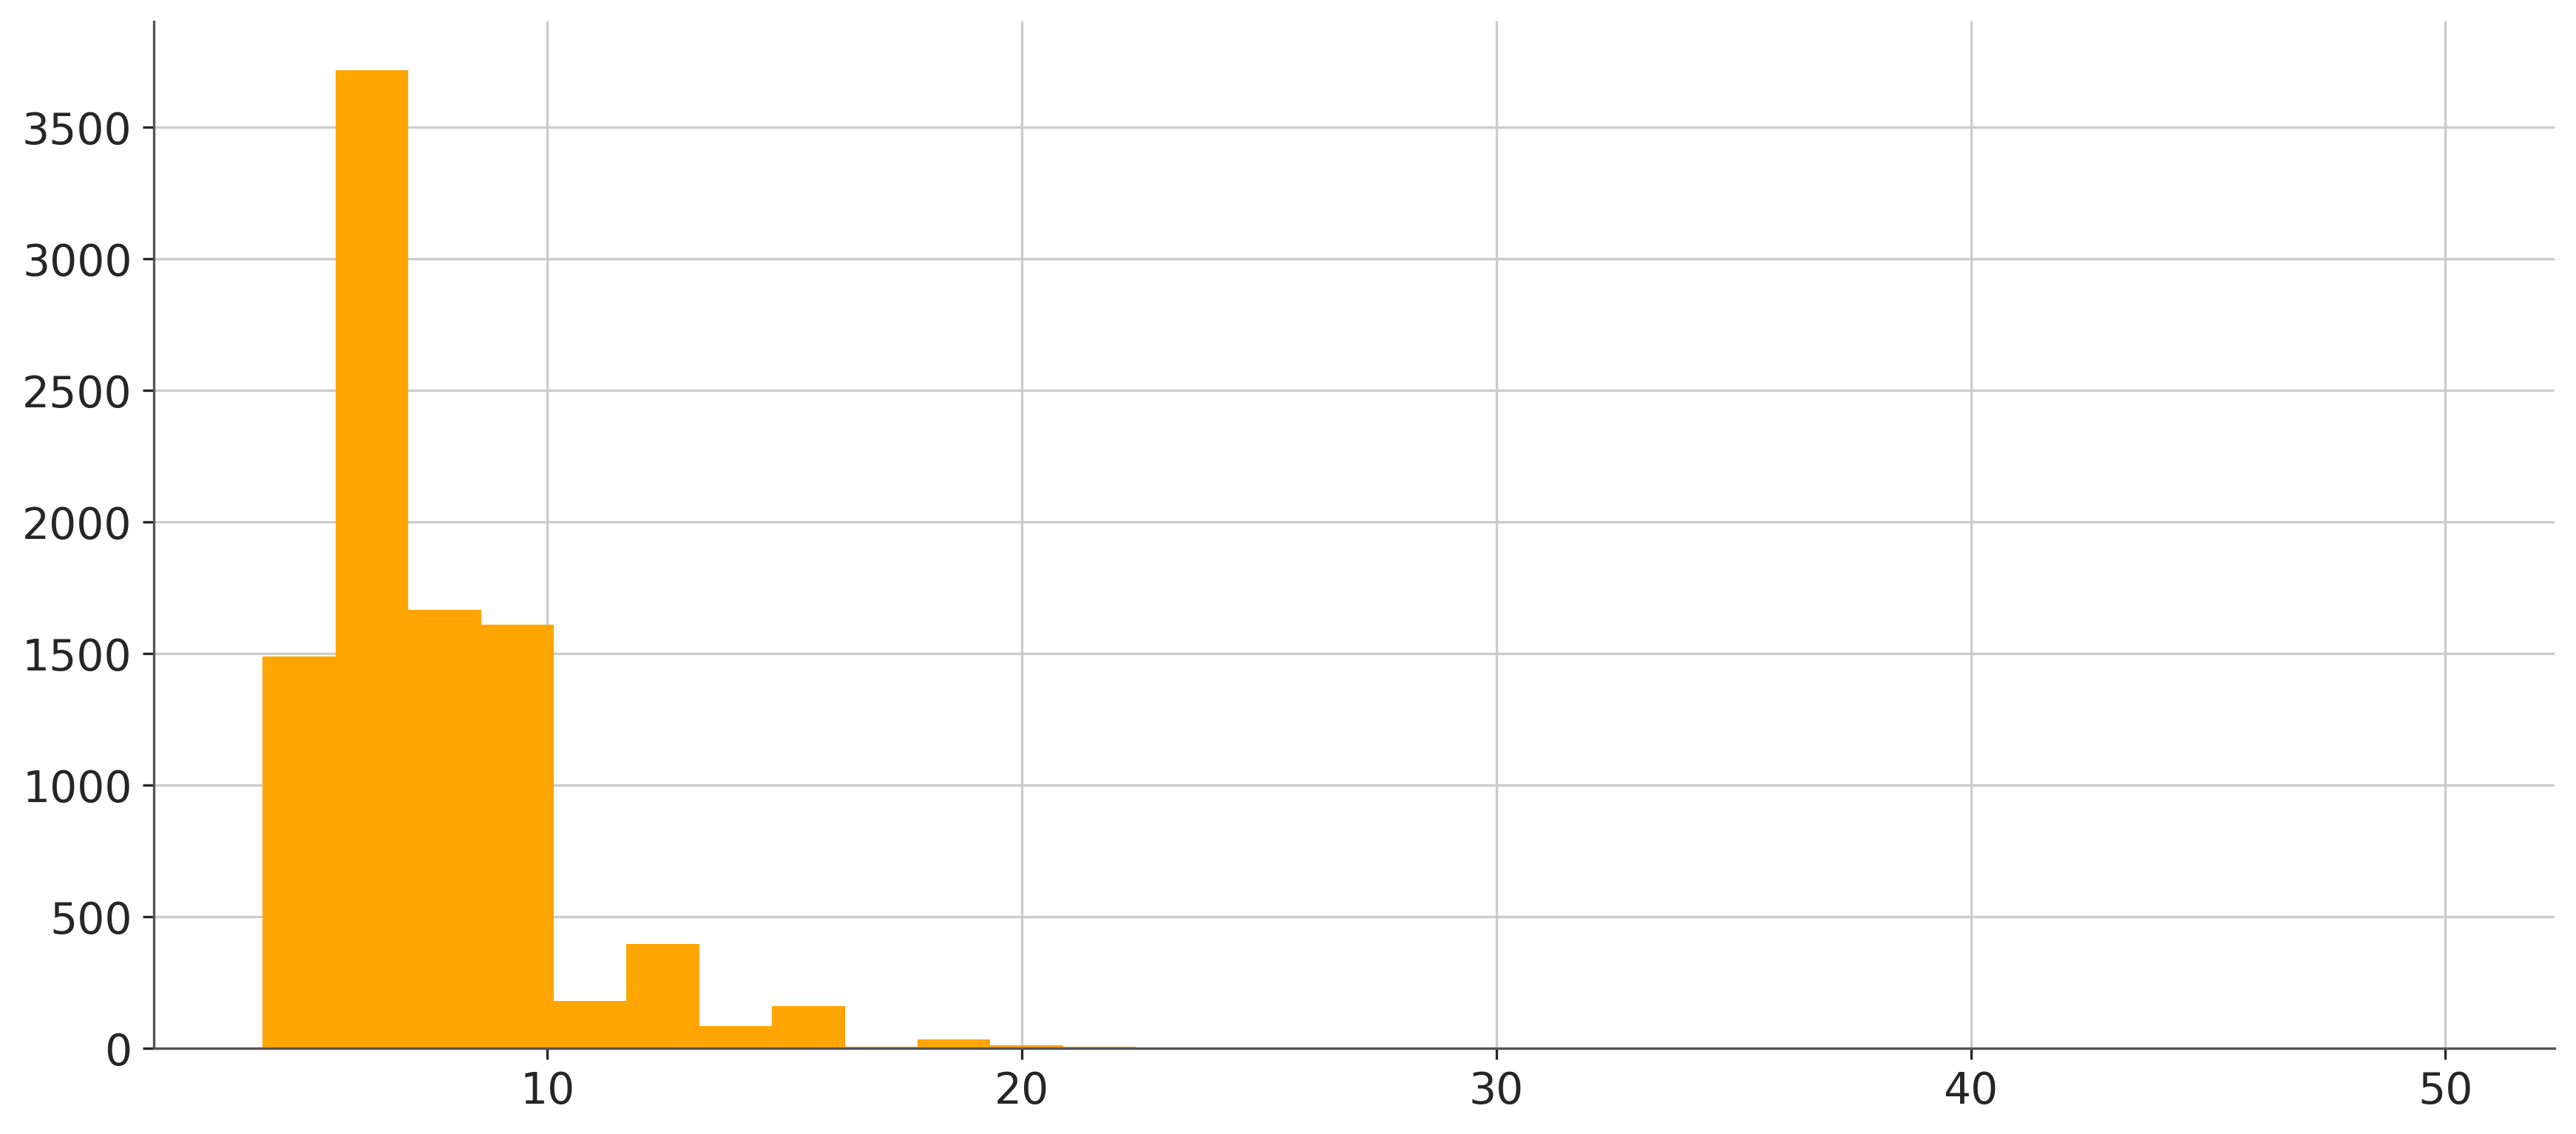

In [6]:
# remove rows where Estimated_numerosity > 24
X = X[X["Estimated_numerosity"].between(4, 50)].copy()

# optional: check result
print(f"Remaining rows: {len(X)}")
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

In [7]:

# Encode entity (trial-level)
entity, entity_labels = pd.factorize(X["entity"])  # shape (n_trials,)
print(entity)

# Extract trial-level numerosity
x_stim = X["Presented_numerosity"].values
y_obs = X["Estimated_numerosity"].values
dose = X["dose"].values

# --- Build subject-level mapping ---
subject_info = X.drop_duplicates("S_ID").sort_values("S_ID")

# Map original S_ID → 0-based integer index (for PyMC)
subject_id_map = {subj: idx for idx, subj in enumerate(subject_info["S_ID"])}
subject_id = X["S_ID"].map(subject_id_map).values.astype(int)  # shape (n_trials,) → ✅ REPEATS ARE OK

# ✅ CORRECT: extract integer group codes at SUBJECT level
ph_type = subject_info["s_param_ph"].cat.codes.values  # shape (n_subjects,), dtype=int

# Optional: sanity checks
assert len(ph_type) == len(subject_info), "Group codes must be per subject"
assert subject_id.max() == len(ph_type) - 1, "subject_id must align with group codes"
assert set(np.unique(ph_type)) <= {0, 1, 2}, "Invalid group codes"

print(f"subject_id {len(subject_id)}")
print(f"ph_type {len(ph_type)}")

[0 0 0 ... 1 1 1]
subject_id 9361
ph_type 118


In [8]:
print(f"Building model ...")
model = build_hierarchical_lnlik(
    x_stim,
    y_obs,
    subject_id,
    ph_type,
    entity
)


Building model ...


Sampling: [beta_mu, beta_sigma, beta_subj, log_alpha_mu, log_alpha_sigma, log_alpha_subj, sigma_group, y]


Text(0, 0.5, 'Density')

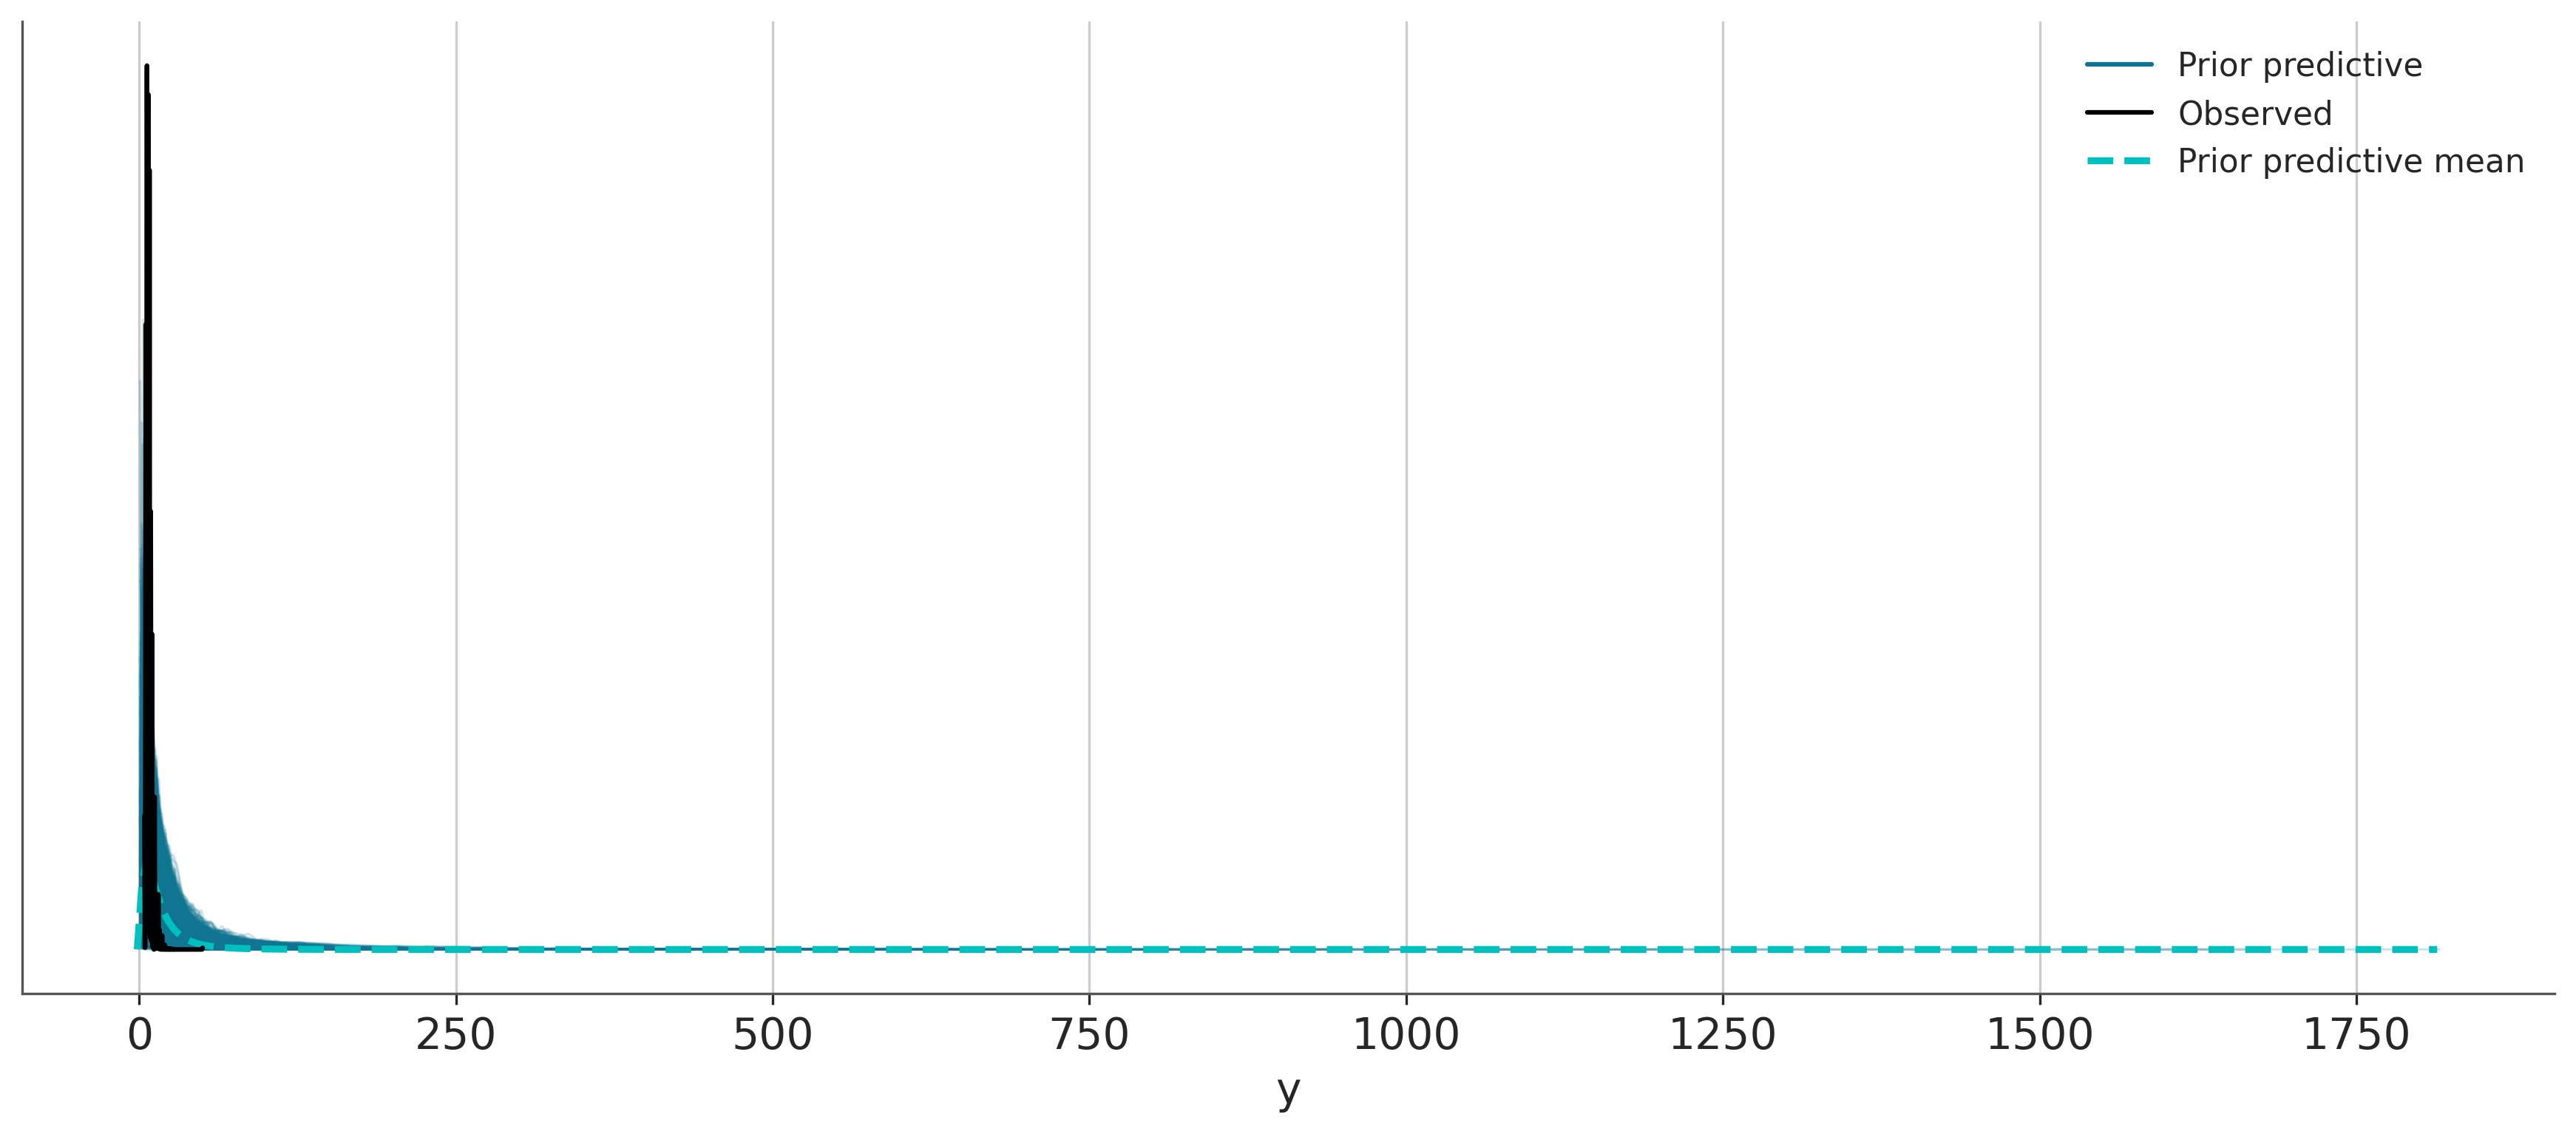

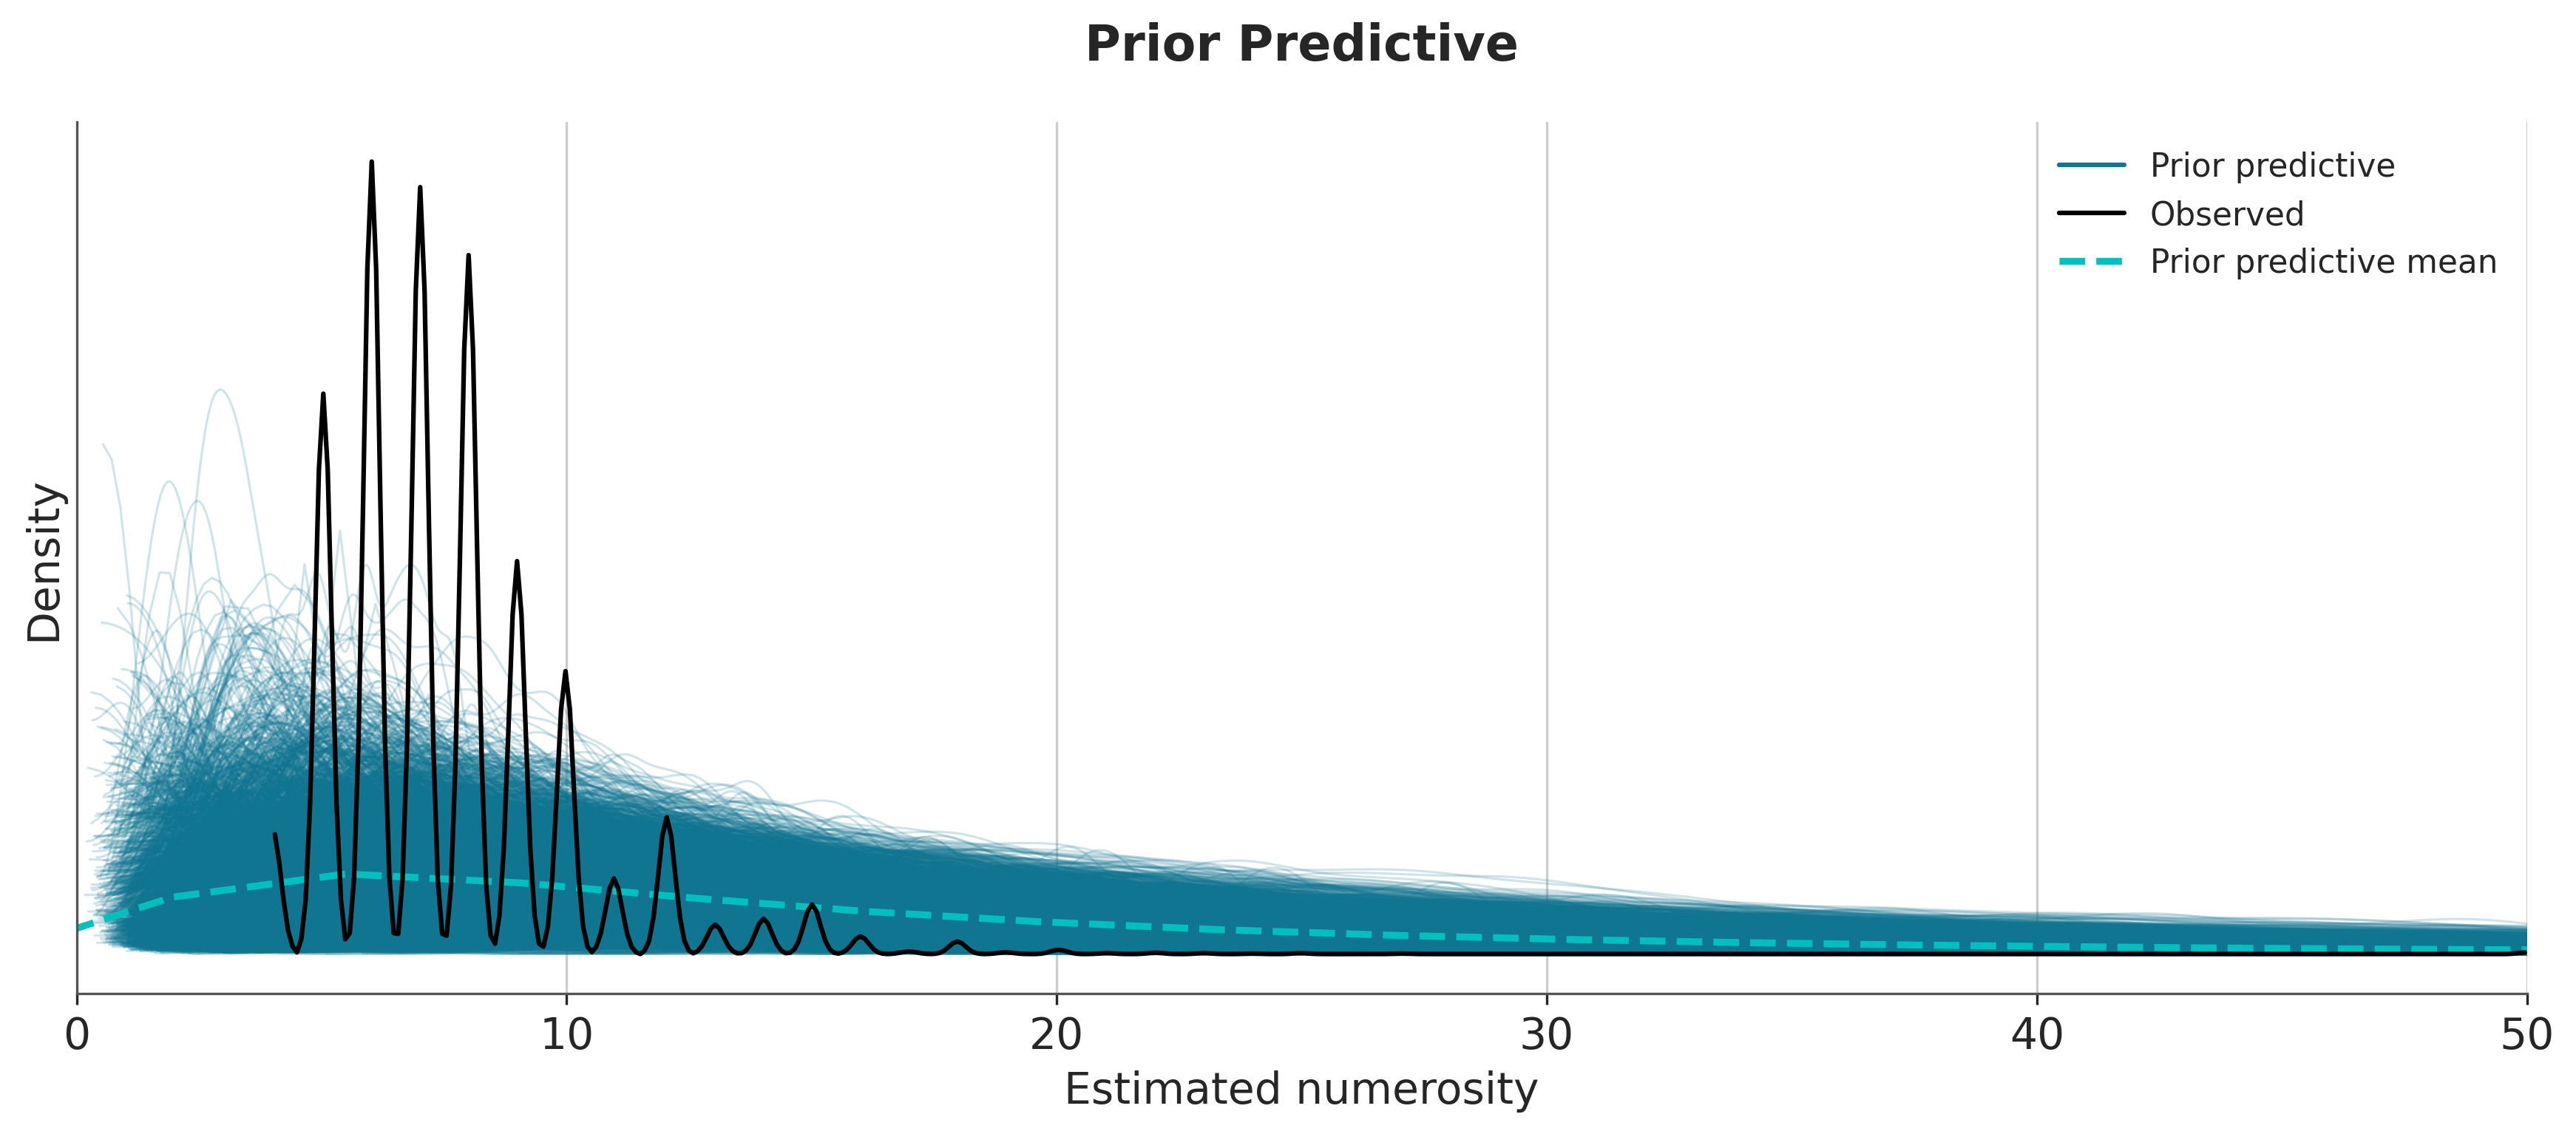

In [9]:
# sanity prior-predictive check
with model:
    prior_pred = pm.sample_prior_predictive(
        samples=5000,
        var_names=["y","y_pred"]
    )

    
axes_full = az.plot_ppc(prior_pred, group="prior", observed="y")
axes_zoom = az.plot_ppc(prior_pred, group="prior", observed="y")
axes_zoom.set_xlim([0,50])
axes_zoom.set_title("Prior Predictive", y=1.05)
axes_zoom.set_xlabel("Estimated numerosity")
axes_zoom.set_ylabel("Density")

In [10]:

sample_config = {
    "draws": 4000,
    "tune": 2000,
    "target_accept": 0.9,
    "chains": 4,
    "random_seed": 94
}

# Sampling
with model:

    trace = pm.sample(**sample_config)

    post_pred = pm.sample_posterior_predictive(trace, var_names=["y", "y_pred"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_alpha_mu, log_alpha_sigma, log_alpha_subj, beta_mu, beta_sigma, beta_subj, sigma_group]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 512 seconds.
Sampling: [y]


Output()

In [14]:
trace.extend(prior_pred)
trace.extend(post_pred)
idata = trace
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
main_vars = ["log_alpha_mu", "log_alpha_sigma", "beta_mu", "beta_sigma", "sigma_group"]

In [15]:
# TODO: save idata object here

## Convergence & Sampling Diagnostics

In [18]:

# Basic diagnostics
az.summary(idata, var_names=main_vars, round_to=2)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_alpha_mu[NH, object]     0.31  0.04    0.24     0.38        0.0      0.0   
log_alpha_mu[NH, human]      0.17  0.04    0.09     0.26        0.0      0.0   
log_alpha_mu[PH, object]     0.24  0.04    0.18     0.31        0.0      0.0   
log_alpha_mu[PH, human]     -0.00  0.07   -0.13     0.13        0.0      0.0   
log_alpha_sigma[NH, object]  0.09  0.03    0.04     0.15        0.0      0.0   
log_alpha_sigma[NH, human]   0.20  0.08    0.07     0.35        0.0      0.0   
log_alpha_sigma[PH, object]  0.08  0.03    0.02     0.13        0.0      0.0   
log_alpha_sigma[PH, human]   0.47  0.06    0.36     0.58        0.0      0.0   
beta_mu[NH, object]          0.86  0.02    0.82     0.90        0.0      0.0   
beta_mu[NH, human]           1.00  0.03    0.95     1.04        0.0      0.0   
beta_mu[PH, object]          0.91  0.02    0.87     0.95        0.0      0.0   
beta_mu[PH, human]           1.12  0.04    1.05     1.18        0.0      0.0   
beta_sigma[NH, object]       0.07  0.01    0.05     0.09        0.0      0.0   
beta_sigma[NH, human]        0.13  0.04    0.07     0.20        0.0      0.0   
beta_sigma[PH, object]       0.07  0.01    0.05     0.09        0.0      0.0   
beta_sigma[PH, human]        0.28  0.03    0.22     0.33        0.0      0.0   
sigma_group[NH]              0.15  0.00    0.15     0.16        0.0      0.0   
sigma_group[PH]              0.16  0.00    0.16     0.16        0.0      0.0   

                             ess_bulk  ess_tail  r_hat  
log_alpha_mu[NH, object]      2067.86   4474.25    1.0  
log_alpha_mu[NH, human]       7257.76   9097.60    1.0  
log_alpha_mu[PH, object]      1506.59   2958.28    1.0  
log_alpha_mu[PH, human]      17259.57  12128.49    1.0  
log_alpha_sigma[NH, object]   1111.21    847.88    1.0  
log_alpha_sigma[NH, human]     603.43   1380.29    1.0  
log_alpha_sigma[PH, object]    499.55    370.87    1.0  
log_alpha_sigma[PH, human]    7510.15   9708.20    1.0  
beta_mu[NH, object]           2350.28   5073.30    1.0  
beta_mu[NH, human]            7871.54  10626.64    1.0  
beta_mu[PH, object]           1679.58   2965.46    1.0  
beta_mu[PH, human]           16245.44  11688.47    1.0  
beta_sigma[NH, object]        6046.86   7963.93    1.0  
beta_sigma[NH, human]          689.30   4149.47    1.0  
beta_sigma[PH, object]        2936.85   1712.69    1.0  
beta_sigma[PH, human]         8102.32   9969.01    1.0  
sigma_group[NH]               2296.80   6433.68    1.0  
sigma_group[PH]              13591.30  10890.22    1.0

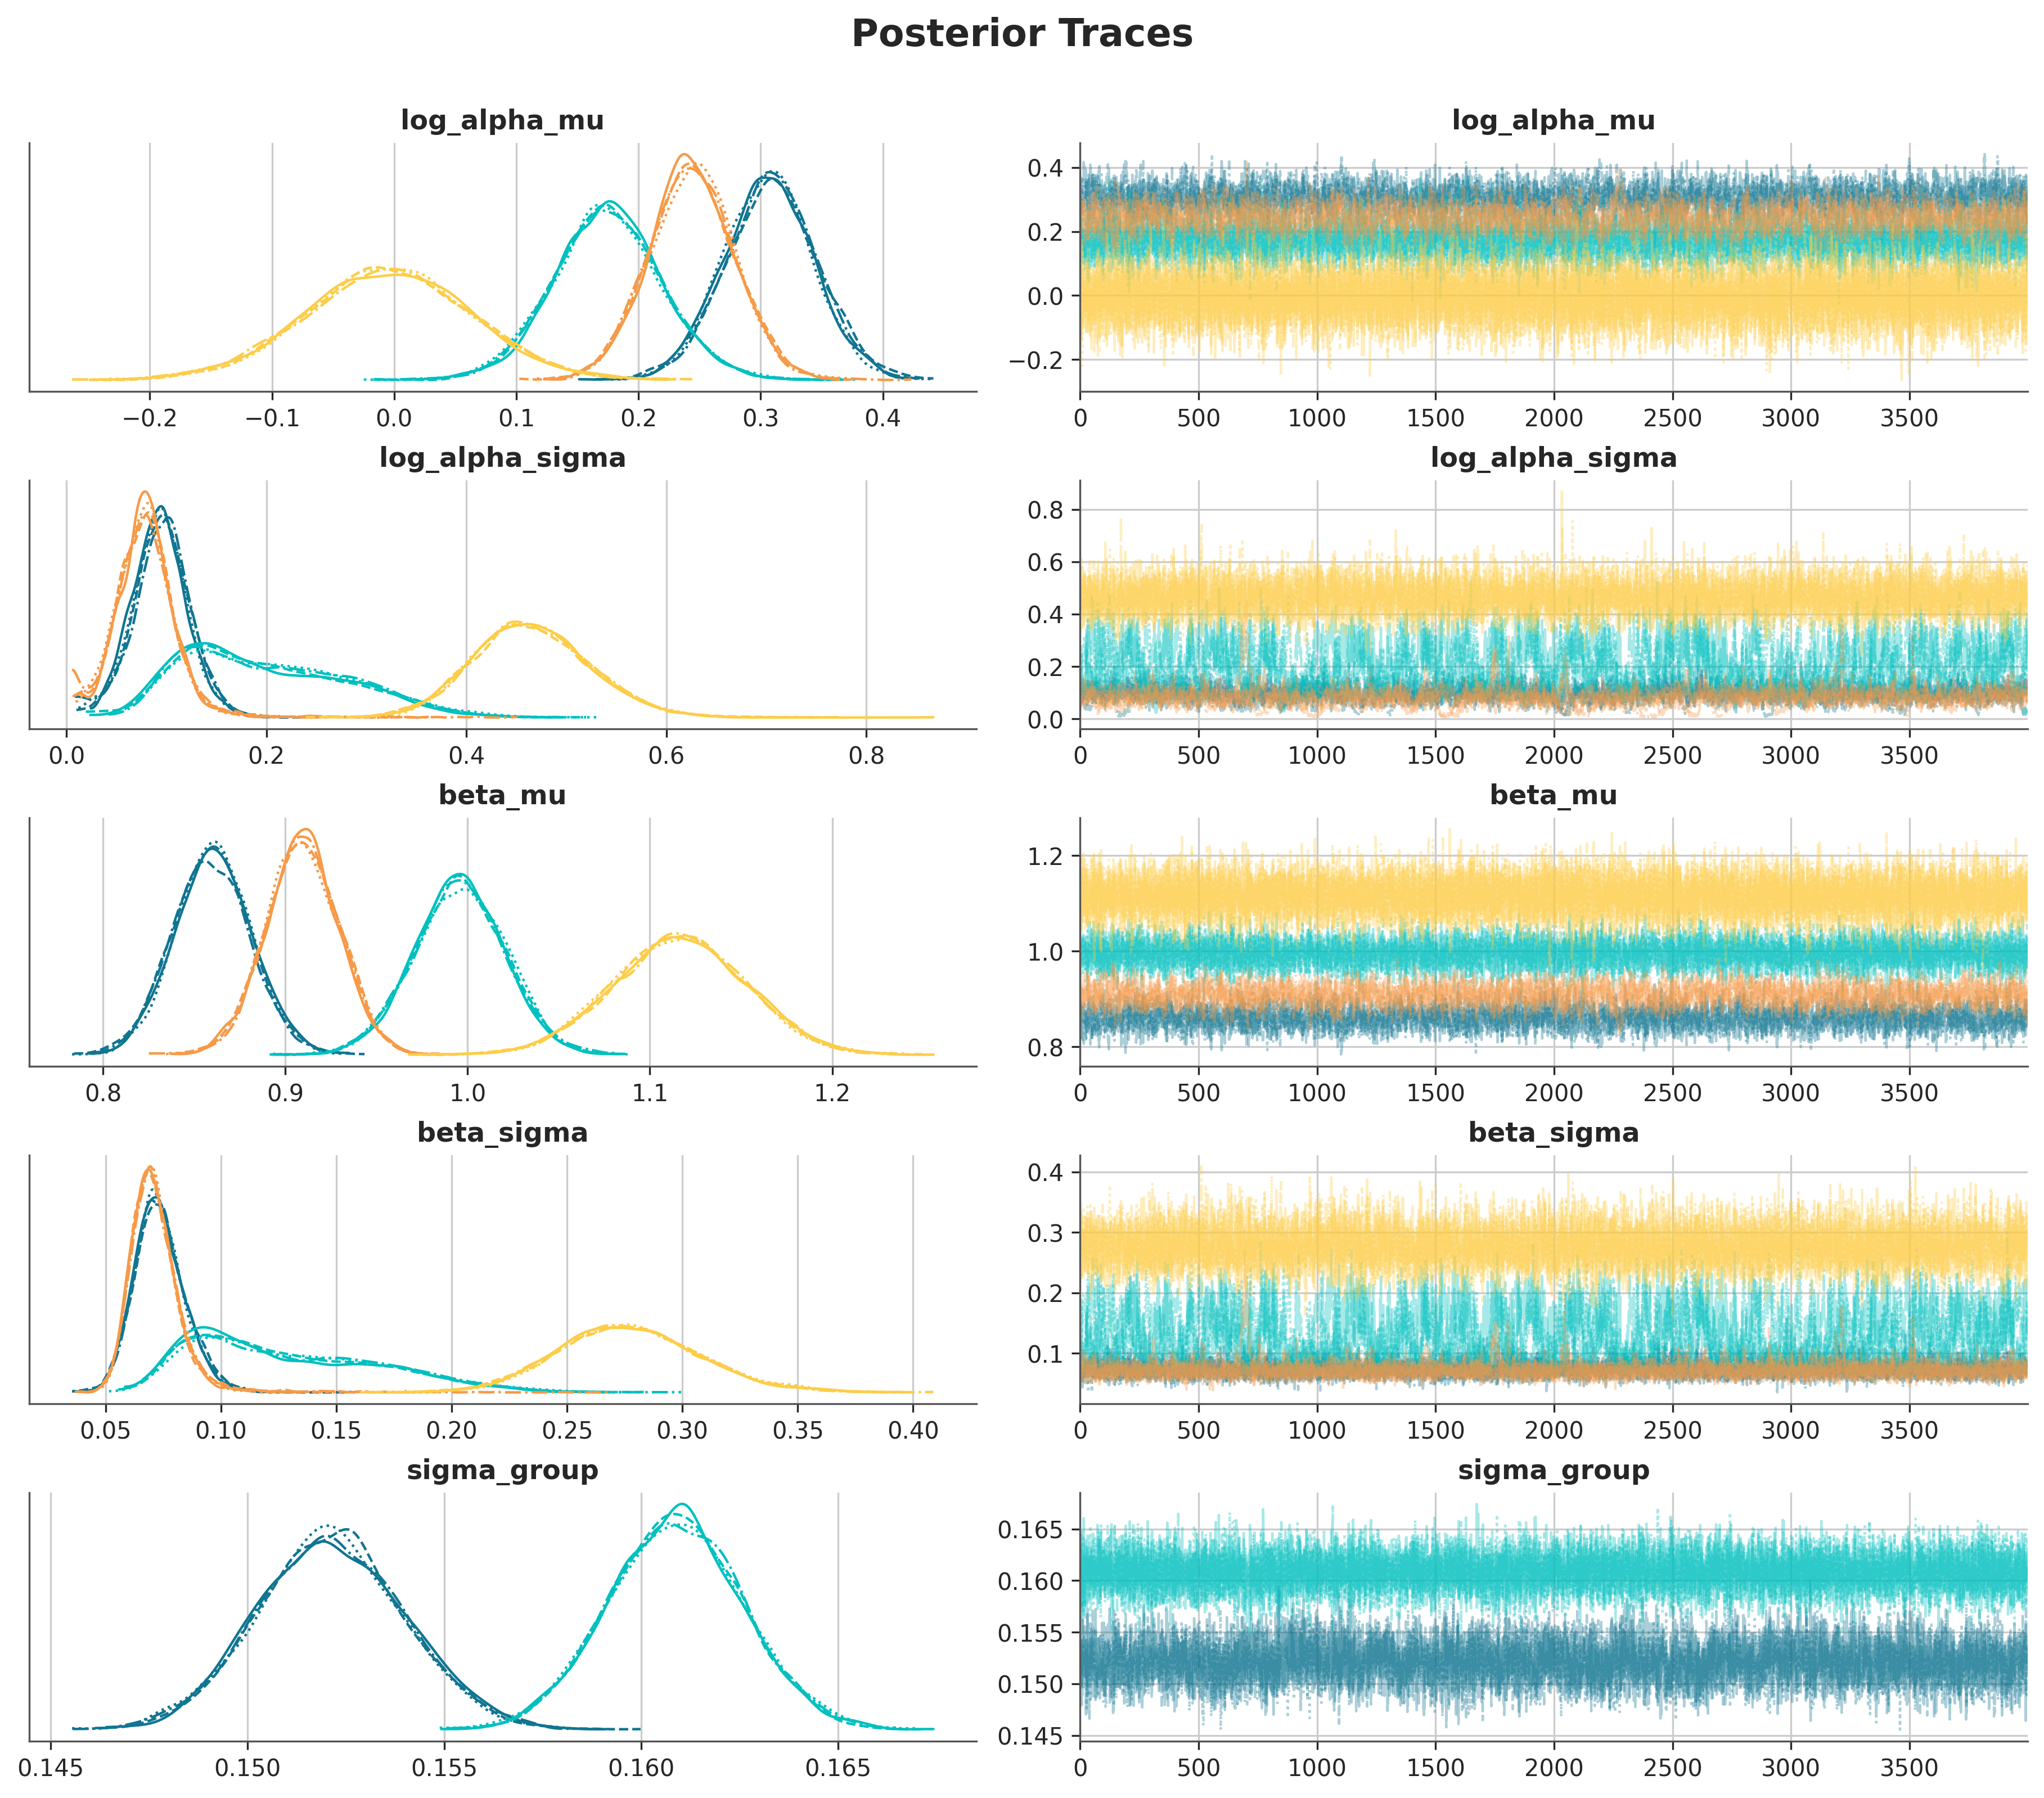

In [19]:
# Trace plots
trace_plot = az.plot_trace(idata, var_names=main_vars)
# axes is your array of Axes
fig = trace_plot[0, 0].figure  # get the figure from the first subplot

# Add a main title
fig.suptitle("Posterior Traces", fontsize=16, y=1.05)  # y>1 moves it up

fig.savefig(plot_dir/"trace_plot.png")

## Posterior Predictive

<Axes: xlabel='y / y_pred'>

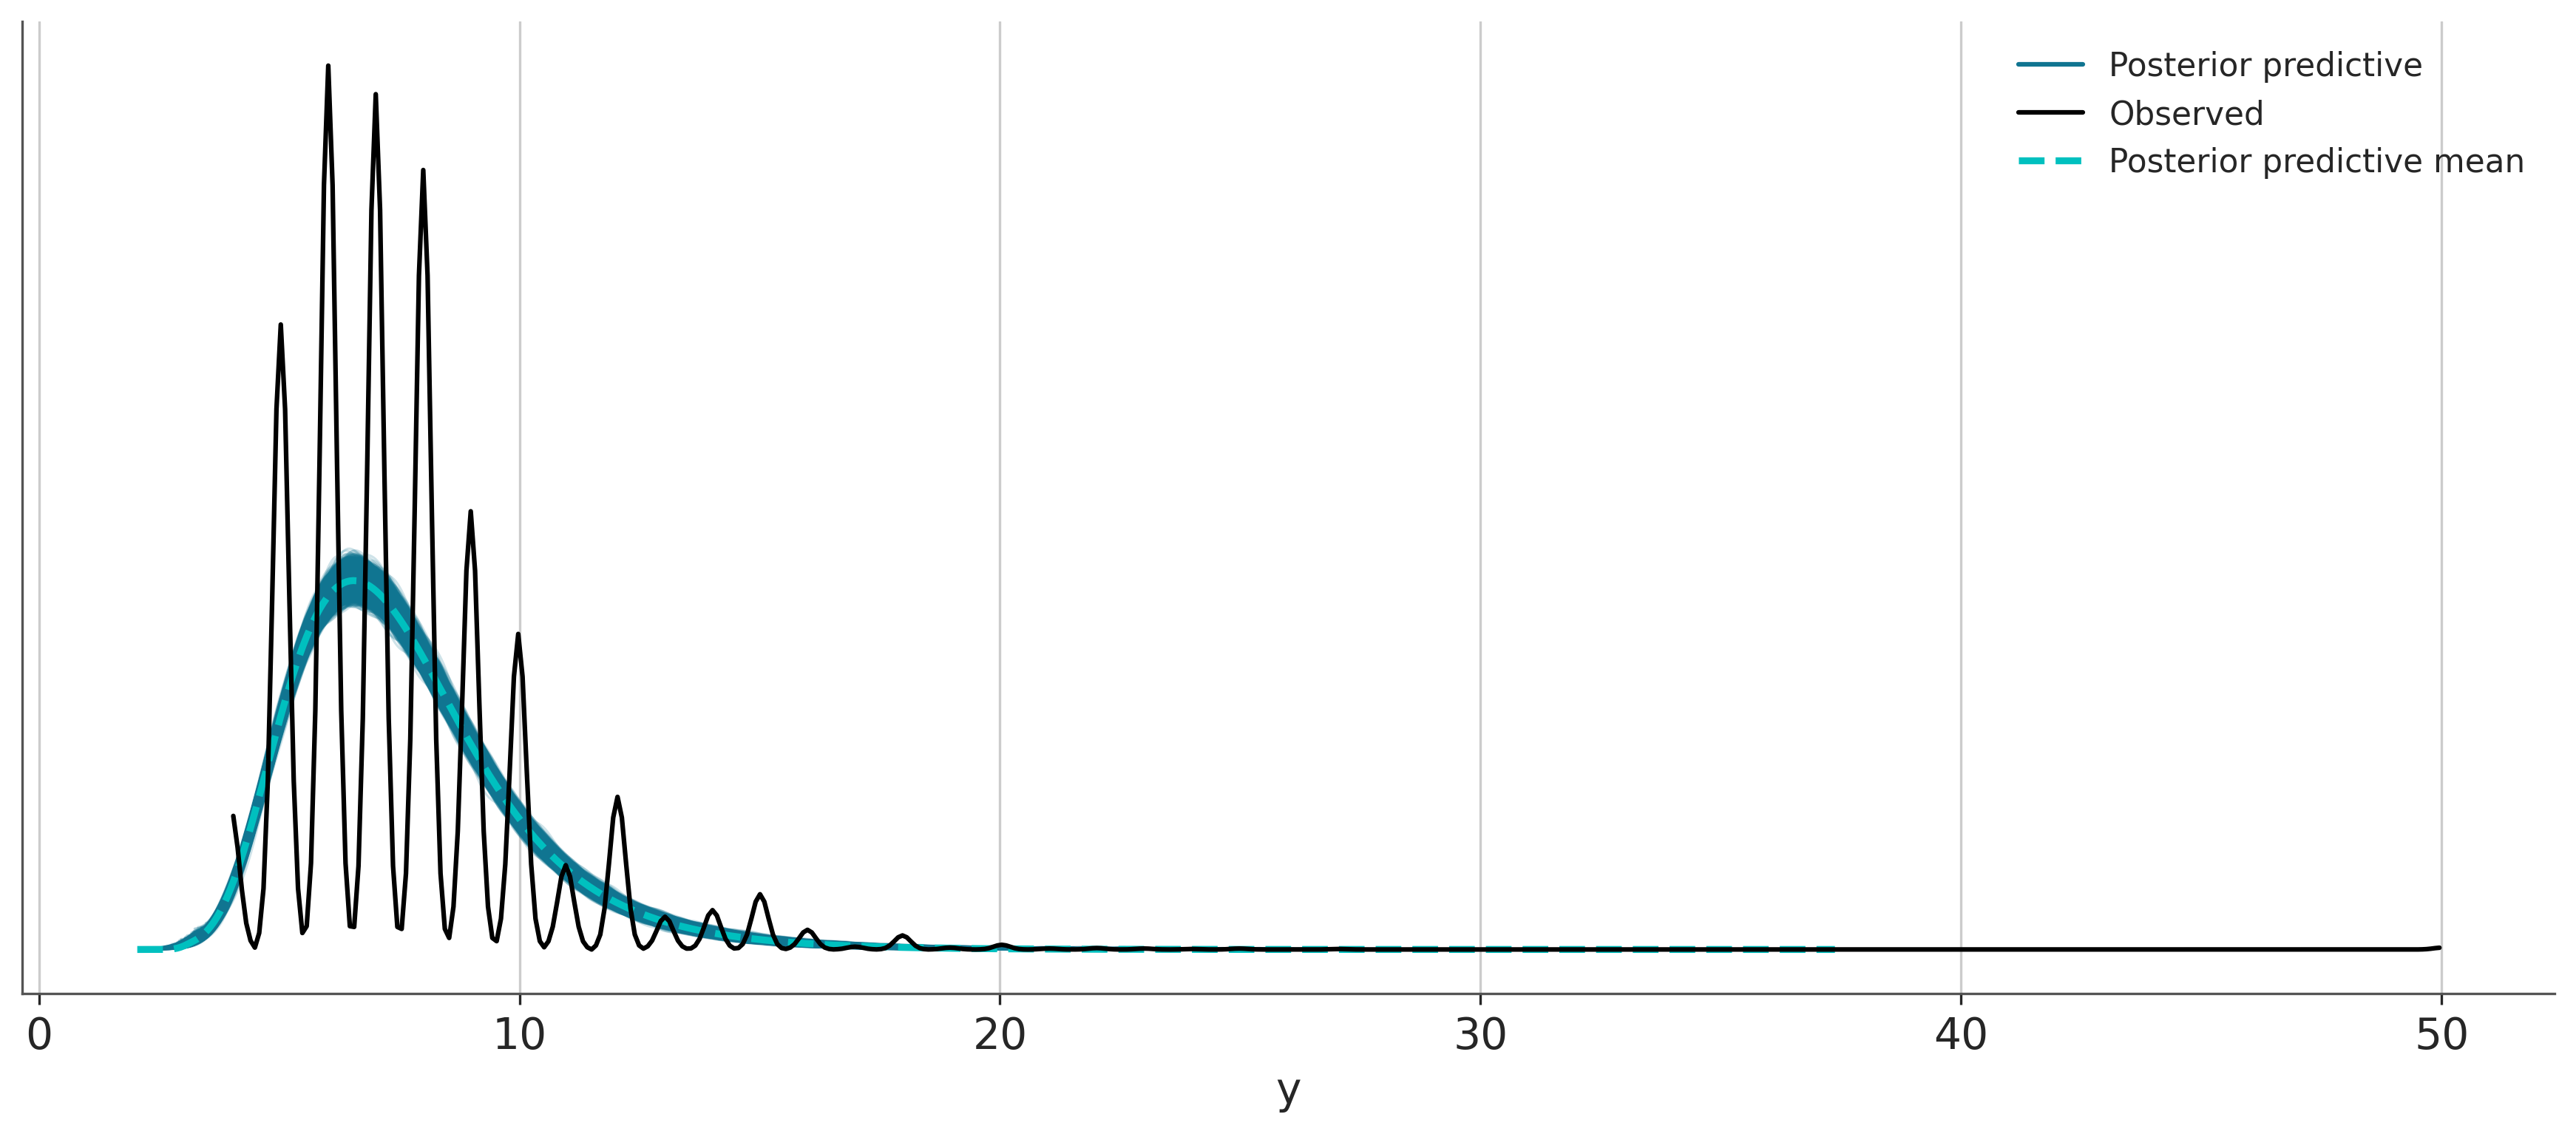

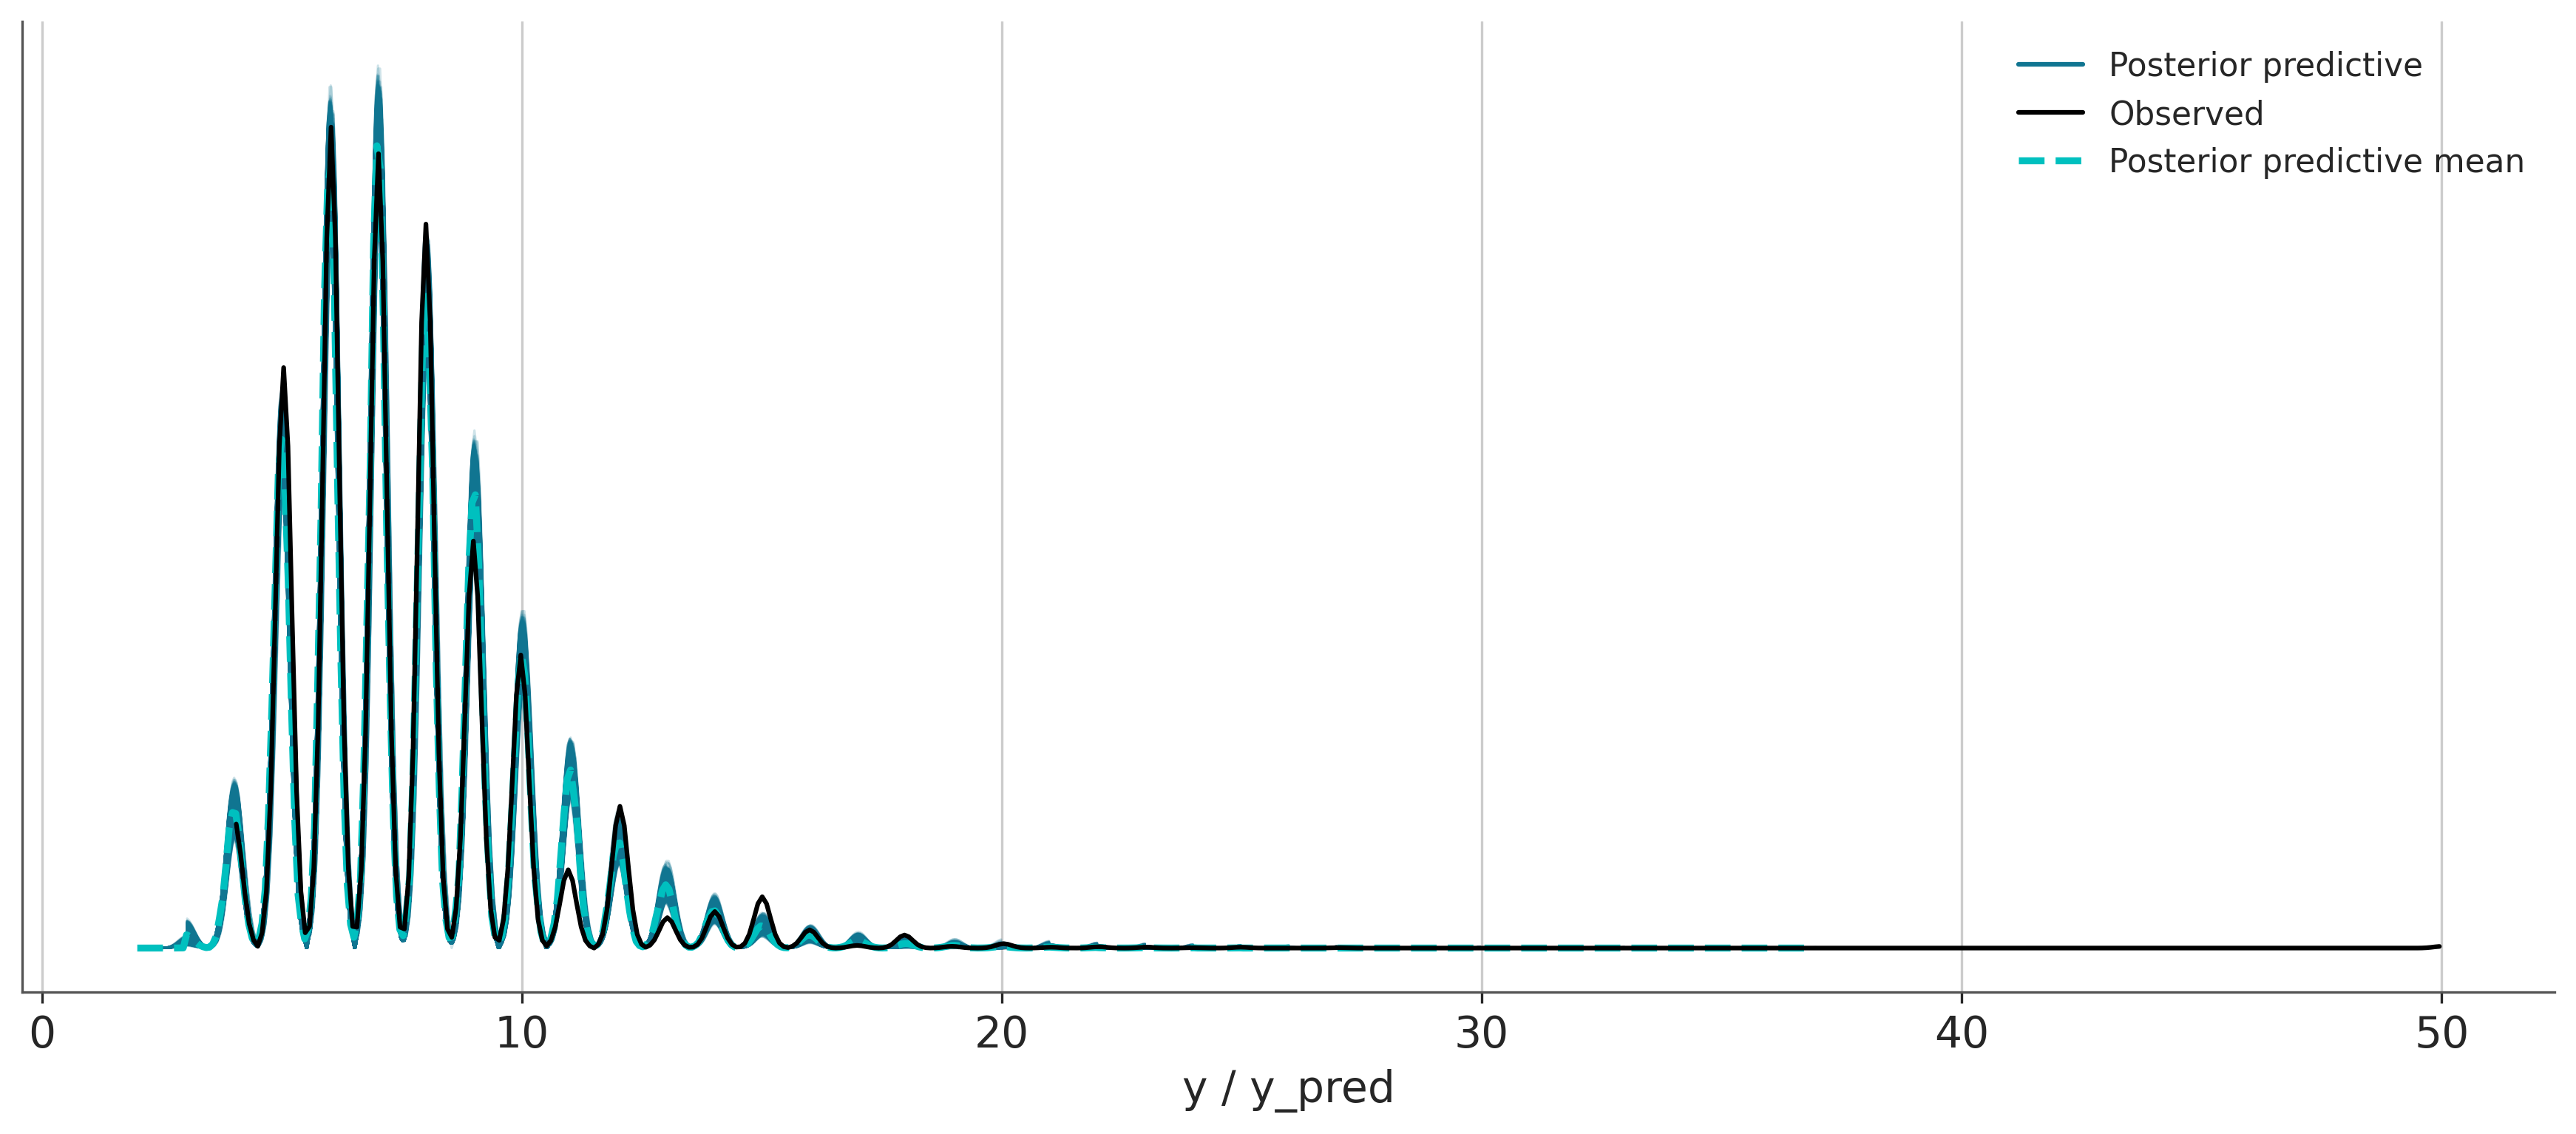

In [20]:
az.plot_ppc(idata)
az.plot_ppc(idata, data_pairs={"y":"y_pred"})

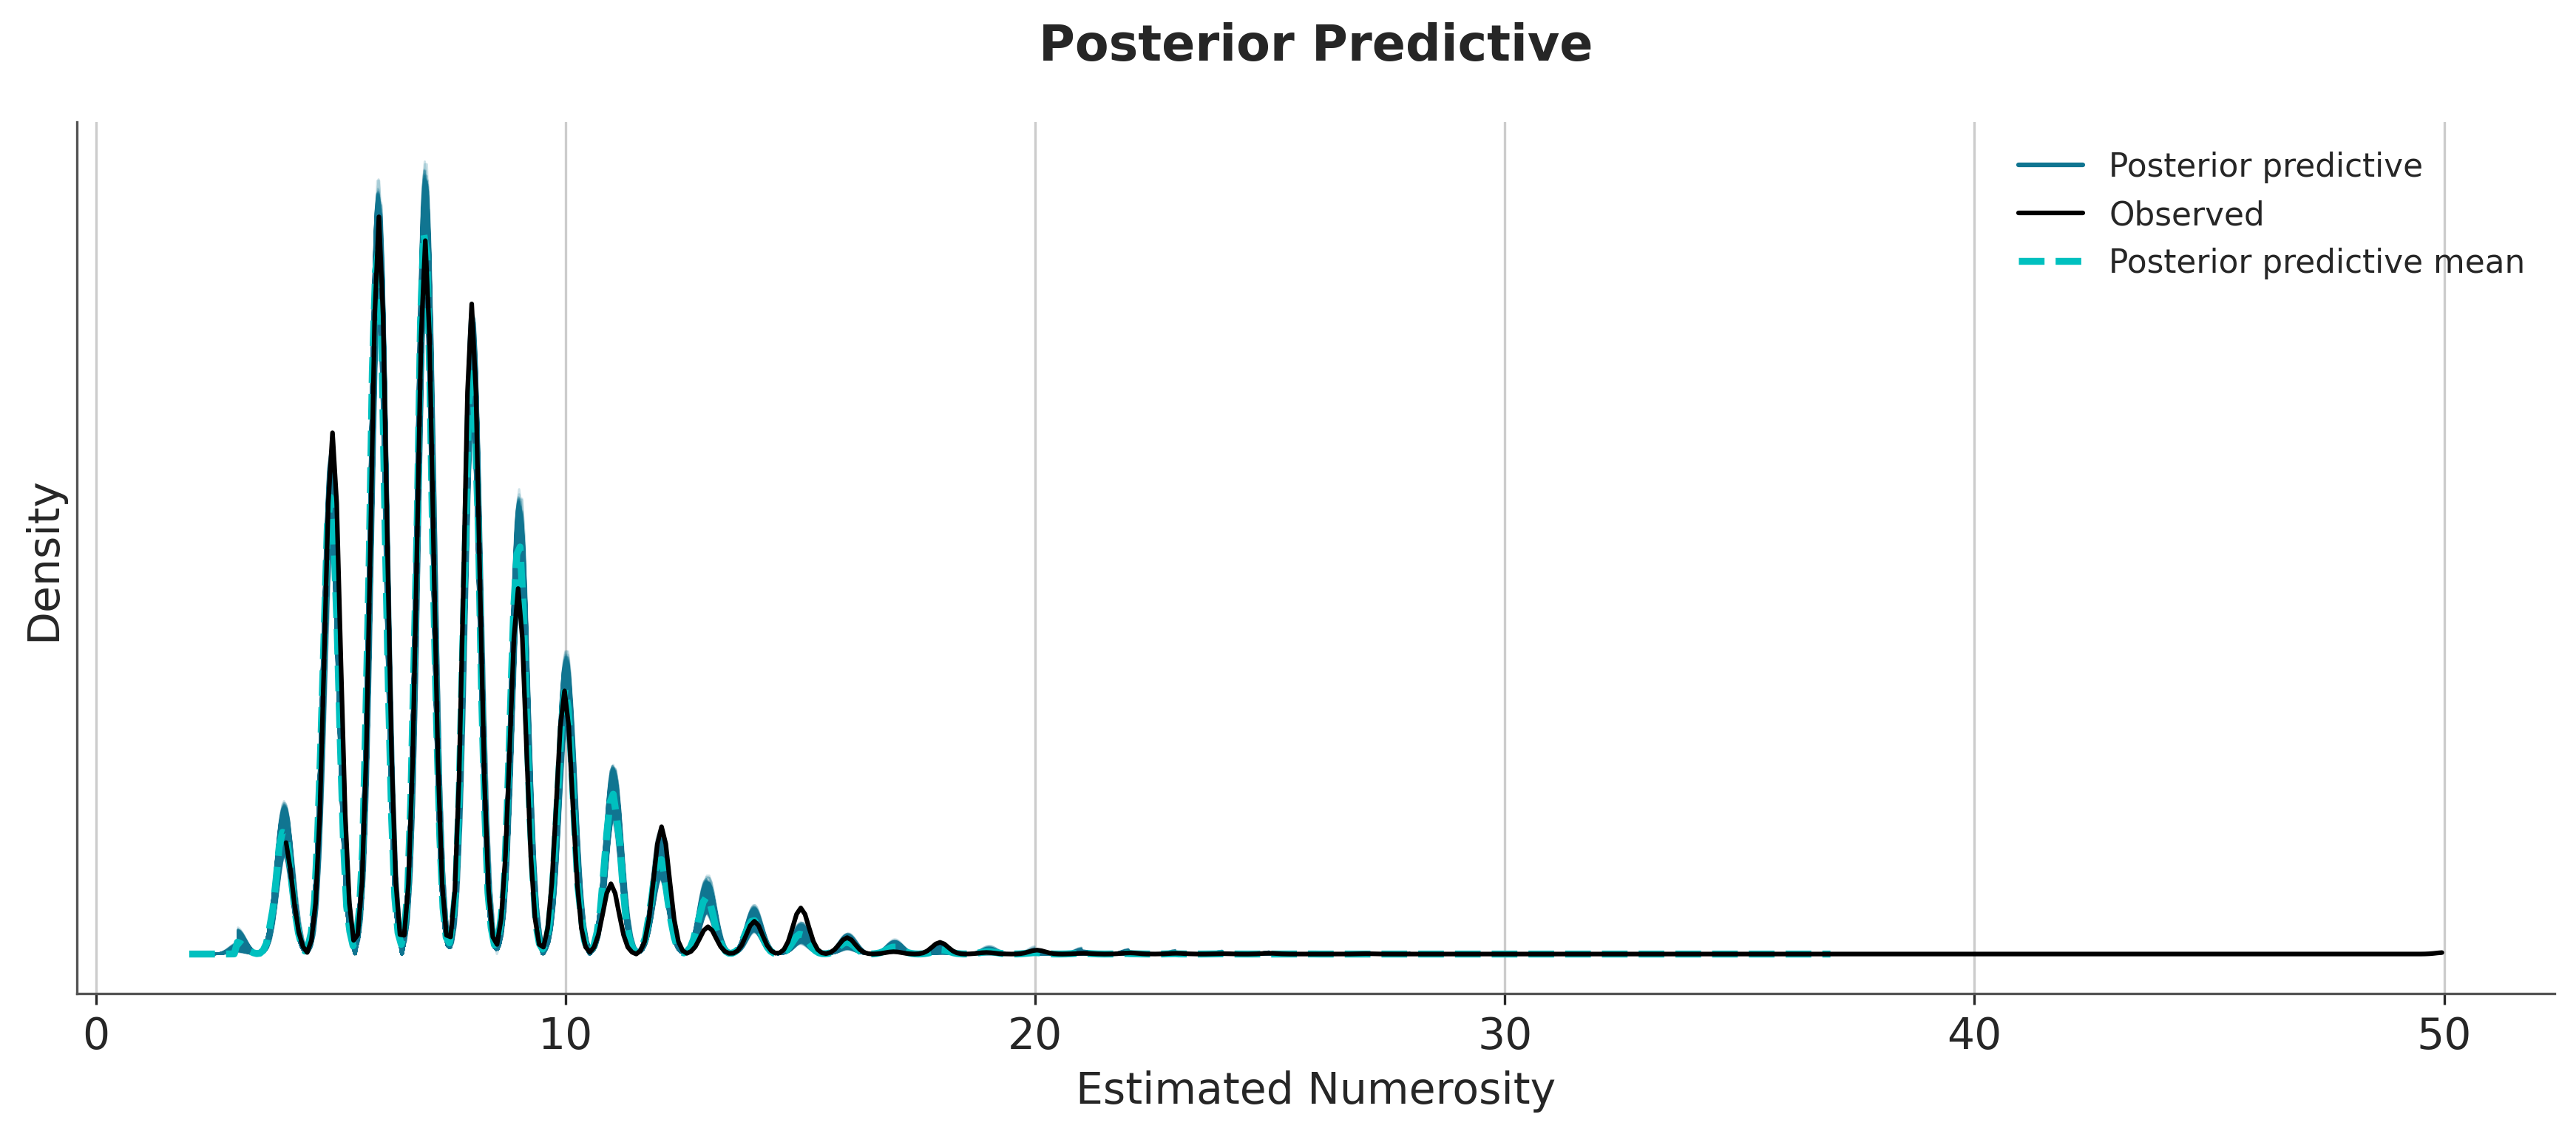

In [21]:
axes = az.plot_ppc(idata, data_pairs={"y":"y_pred"})

# Set title and x-label
axes.set_title("Posterior Predictive", y=1.05)
axes.set_xlabel("Estimated Numerosity")
axes.set_ylabel("Density")

# Save figure
post_pred_ = axes.figure  # get figure from axes
fig.savefig(plot_dir/"prior_pred.png")


## Posterior Summaries of Key Group Parameters


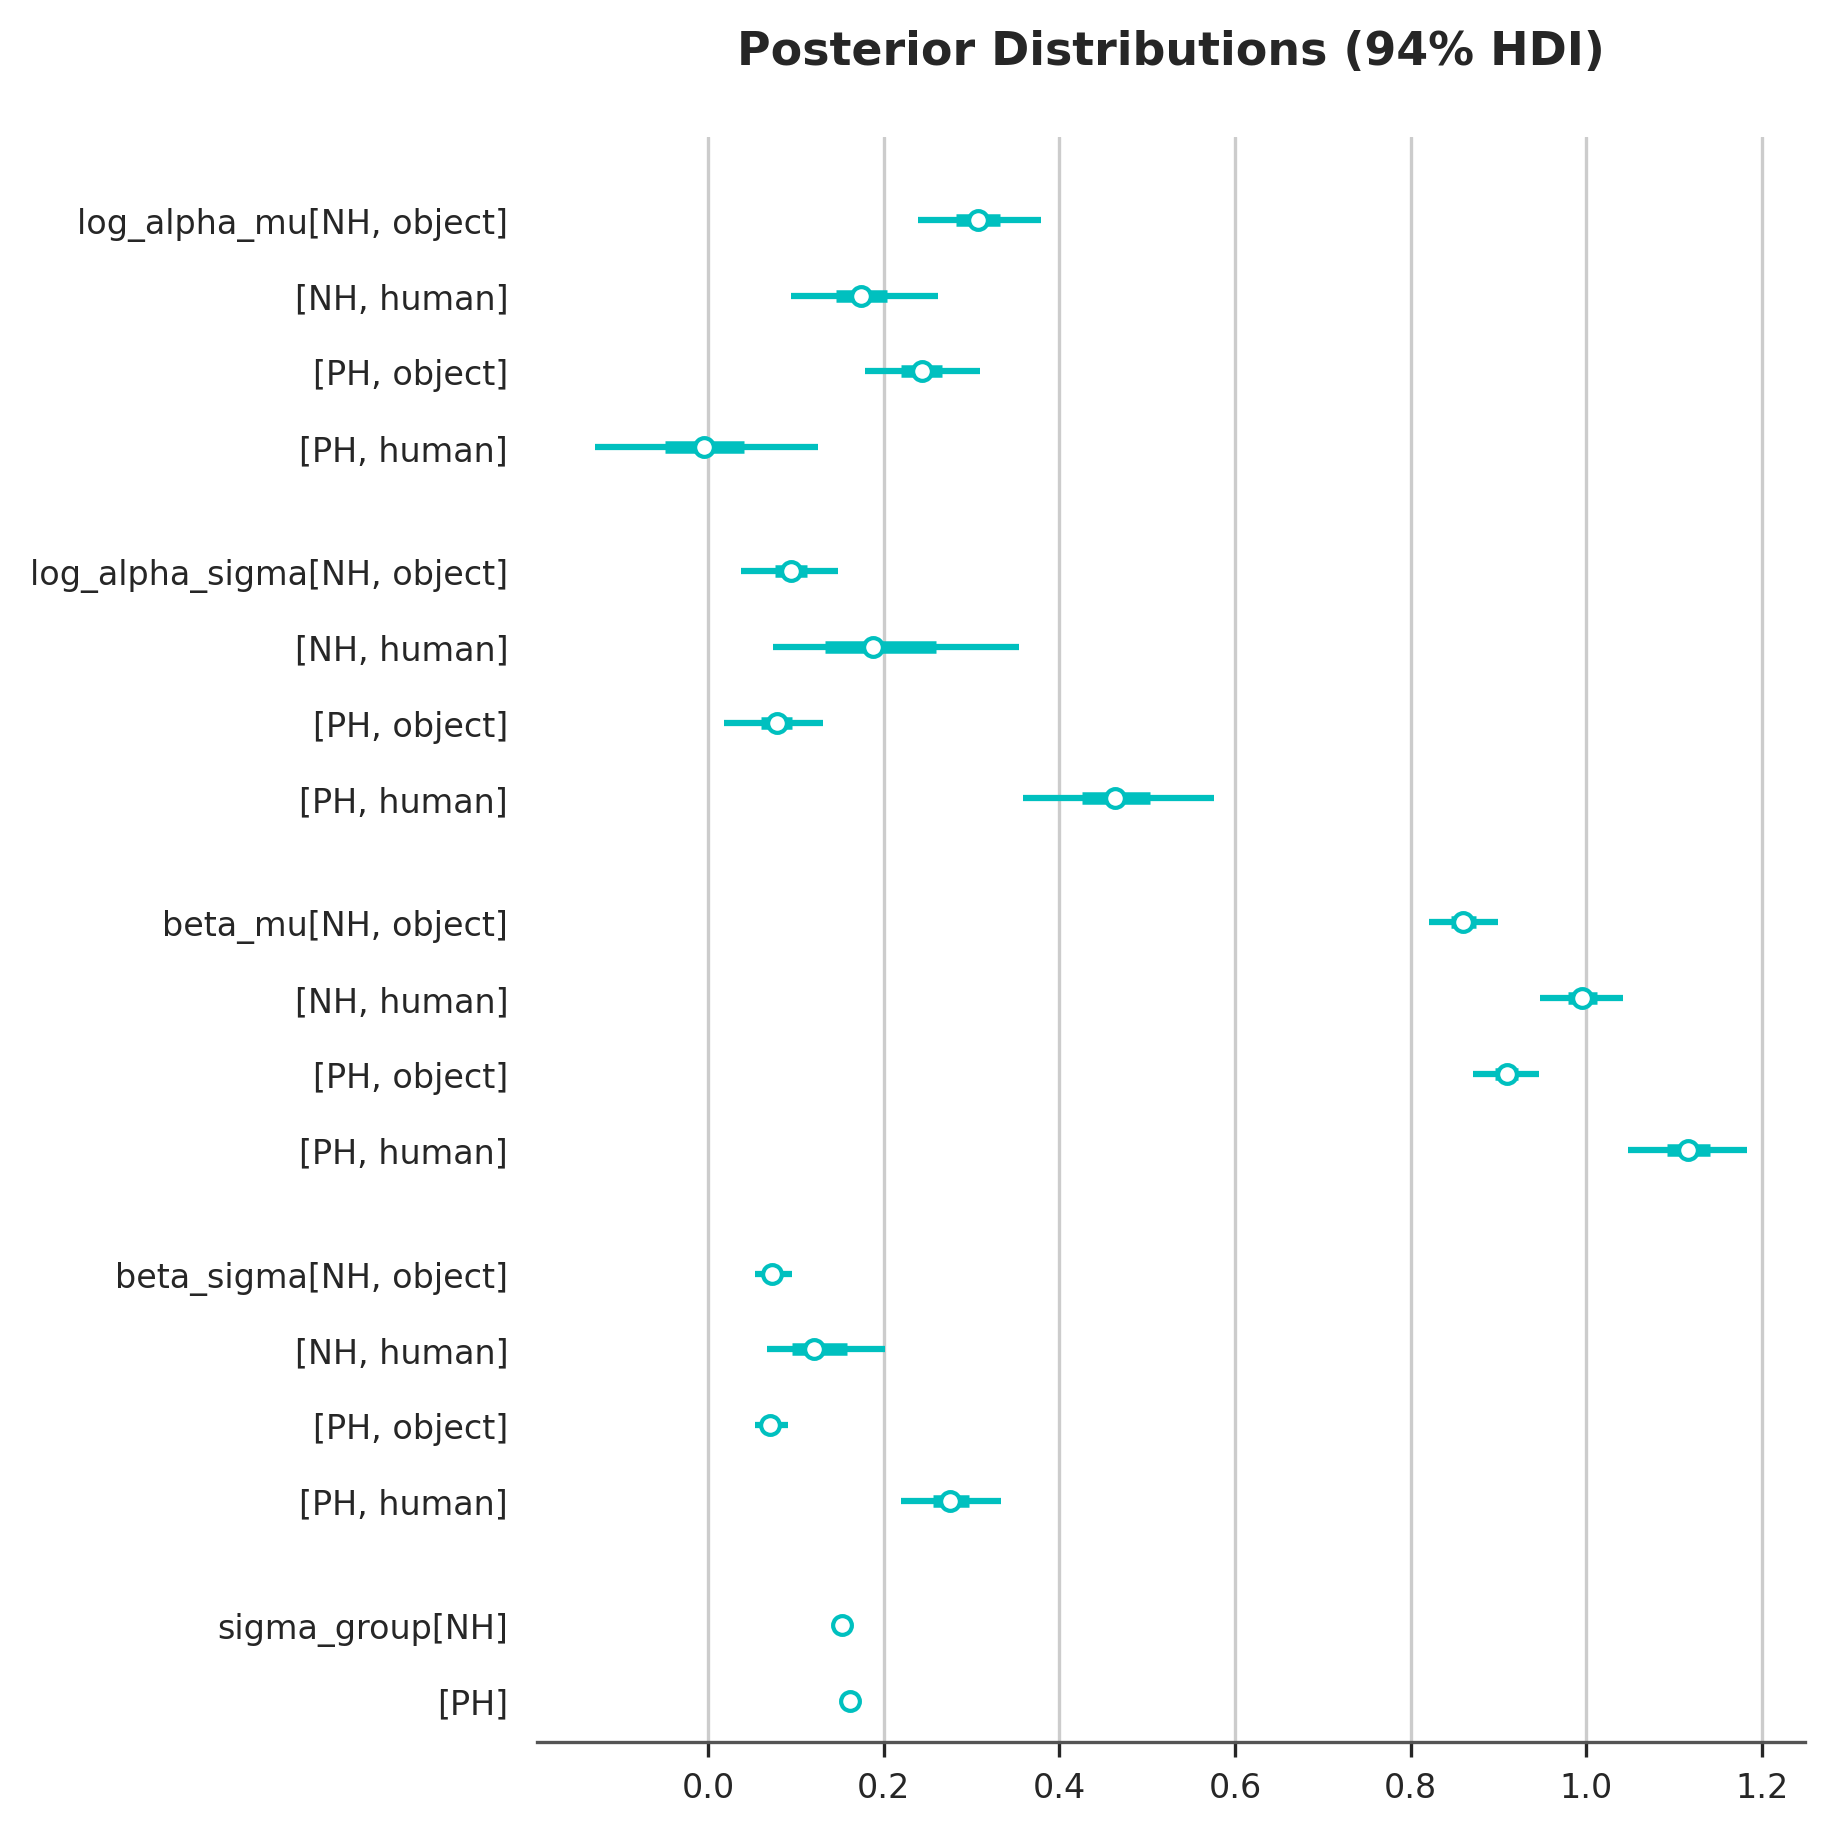

In [96]:
# Temporarily set smaller font sizes
with plt.rc_context({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 7
}):
    ax = az.plot_forest(
        idata,
        var_names=main_vars,
        combined=True,
        hdi_prob=0.94,
        colors="C1",
        figsize=(6,6)
    )
    ax[0].set_title("Posterior Distributions (94% HDI)", fontsize=11, y=1.03)

    plt.savefig(plot_dir / "forest.png", dpi=150, bbox_inches="tight")

Plot summary table

In [23]:
# Group-level bias in scaling (alpha)
summary = az.summary(idata, var_names=main_vars, round_to=2)
print(summary)

                             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_alpha_mu[NH, object]     0.31  0.04    0.24     0.38        0.0      0.0   
log_alpha_mu[NH, human]      0.17  0.04    0.09     0.26        0.0      0.0   
log_alpha_mu[PH, object]     0.24  0.04    0.18     0.31        0.0      0.0   
log_alpha_mu[PH, human]     -0.00  0.07   -0.13     0.13        0.0      0.0   
log_alpha_sigma[NH, object]  0.09  0.03    0.04     0.15        0.0      0.0   
log_alpha_sigma[NH, human]   0.20  0.08    0.07     0.35        0.0      0.0   
log_alpha_sigma[PH, object]  0.08  0.03    0.02     0.13        0.0      0.0   
log_alpha_sigma[PH, human]   0.47  0.06    0.36     0.58        0.0      0.0   
beta_mu[NH, object]          0.86  0.02    0.82     0.90        0.0      0.0   
beta_mu[NH, human]           1.00  0.03    0.95     1.04        0.0      0.0   
beta_mu[PH, object]          0.91  0.02    0.87     0.95        0.0      0.0   
beta_mu[PH, human]           1.12  0.04 

In [59]:
summary = az.summary(idata, var_names=main_vars, round_to=3)
summary.reset_index(inplace=True)
summary.rename(columns={"index": "var"})
summary.drop(columns=["mcse_mean", "mcse_sd"], axis=1, inplace=True)

In [66]:
# Define column widths: first column wider, others narrower
col_widths = [200] + [80] * (len(summary.columns) - 1)  # adjust numbers as needed

fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary.columns),
        fill_color="lightblue",
        align="left",
        font=dict(family="Arial Black", color="black", size=14),
        height=30,
        line_color="lightgrey",   # border around header cells
        line_width=0,
    ),
    cells=dict(
        values=[summary[col] for col in summary.columns],
        fill_color="white",
        align="left",
        font=dict(family="Arial",color="black", size=14),
        height=40,
        line_color="lightgrey",   # adds lines between all cell edges
        line_width=1                  # including horizontal row lines
    ),
    columnwidth=col_widths  # <-- apply custom widths
)])

fig.update_layout(
    autosize=False,
    width=sum(col_widths) + 40,  # small padding for borders/margins
    height=800,
    margin=dict(l=10, r=10, t=30, b=10),

)

# To save as a PNG (requires Kaleido)
fig.write_image(plot_dir/"summary_table.png")

# Or just show interactively
fig.show()

## Hypothesis testing

A theoretical investigation based on summary mean values into the overestimation of human numerosity in parkinsons patients.

In [ ]:
alpha_summary = az.summary(idata, var_names=["alpha_group_mu"], round_to=3)
alpha_summary

In [ ]:
az.summary(idata, var_names=["delta_alpha_group_entity", "delta_beta_group_entity"], round_to=3)

Plot the posterior predictive curves given the mean values of 

In [ ]:
main_vars

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_64249/2331581333.py:105: UserWarning:

The figure layout has changed to tight



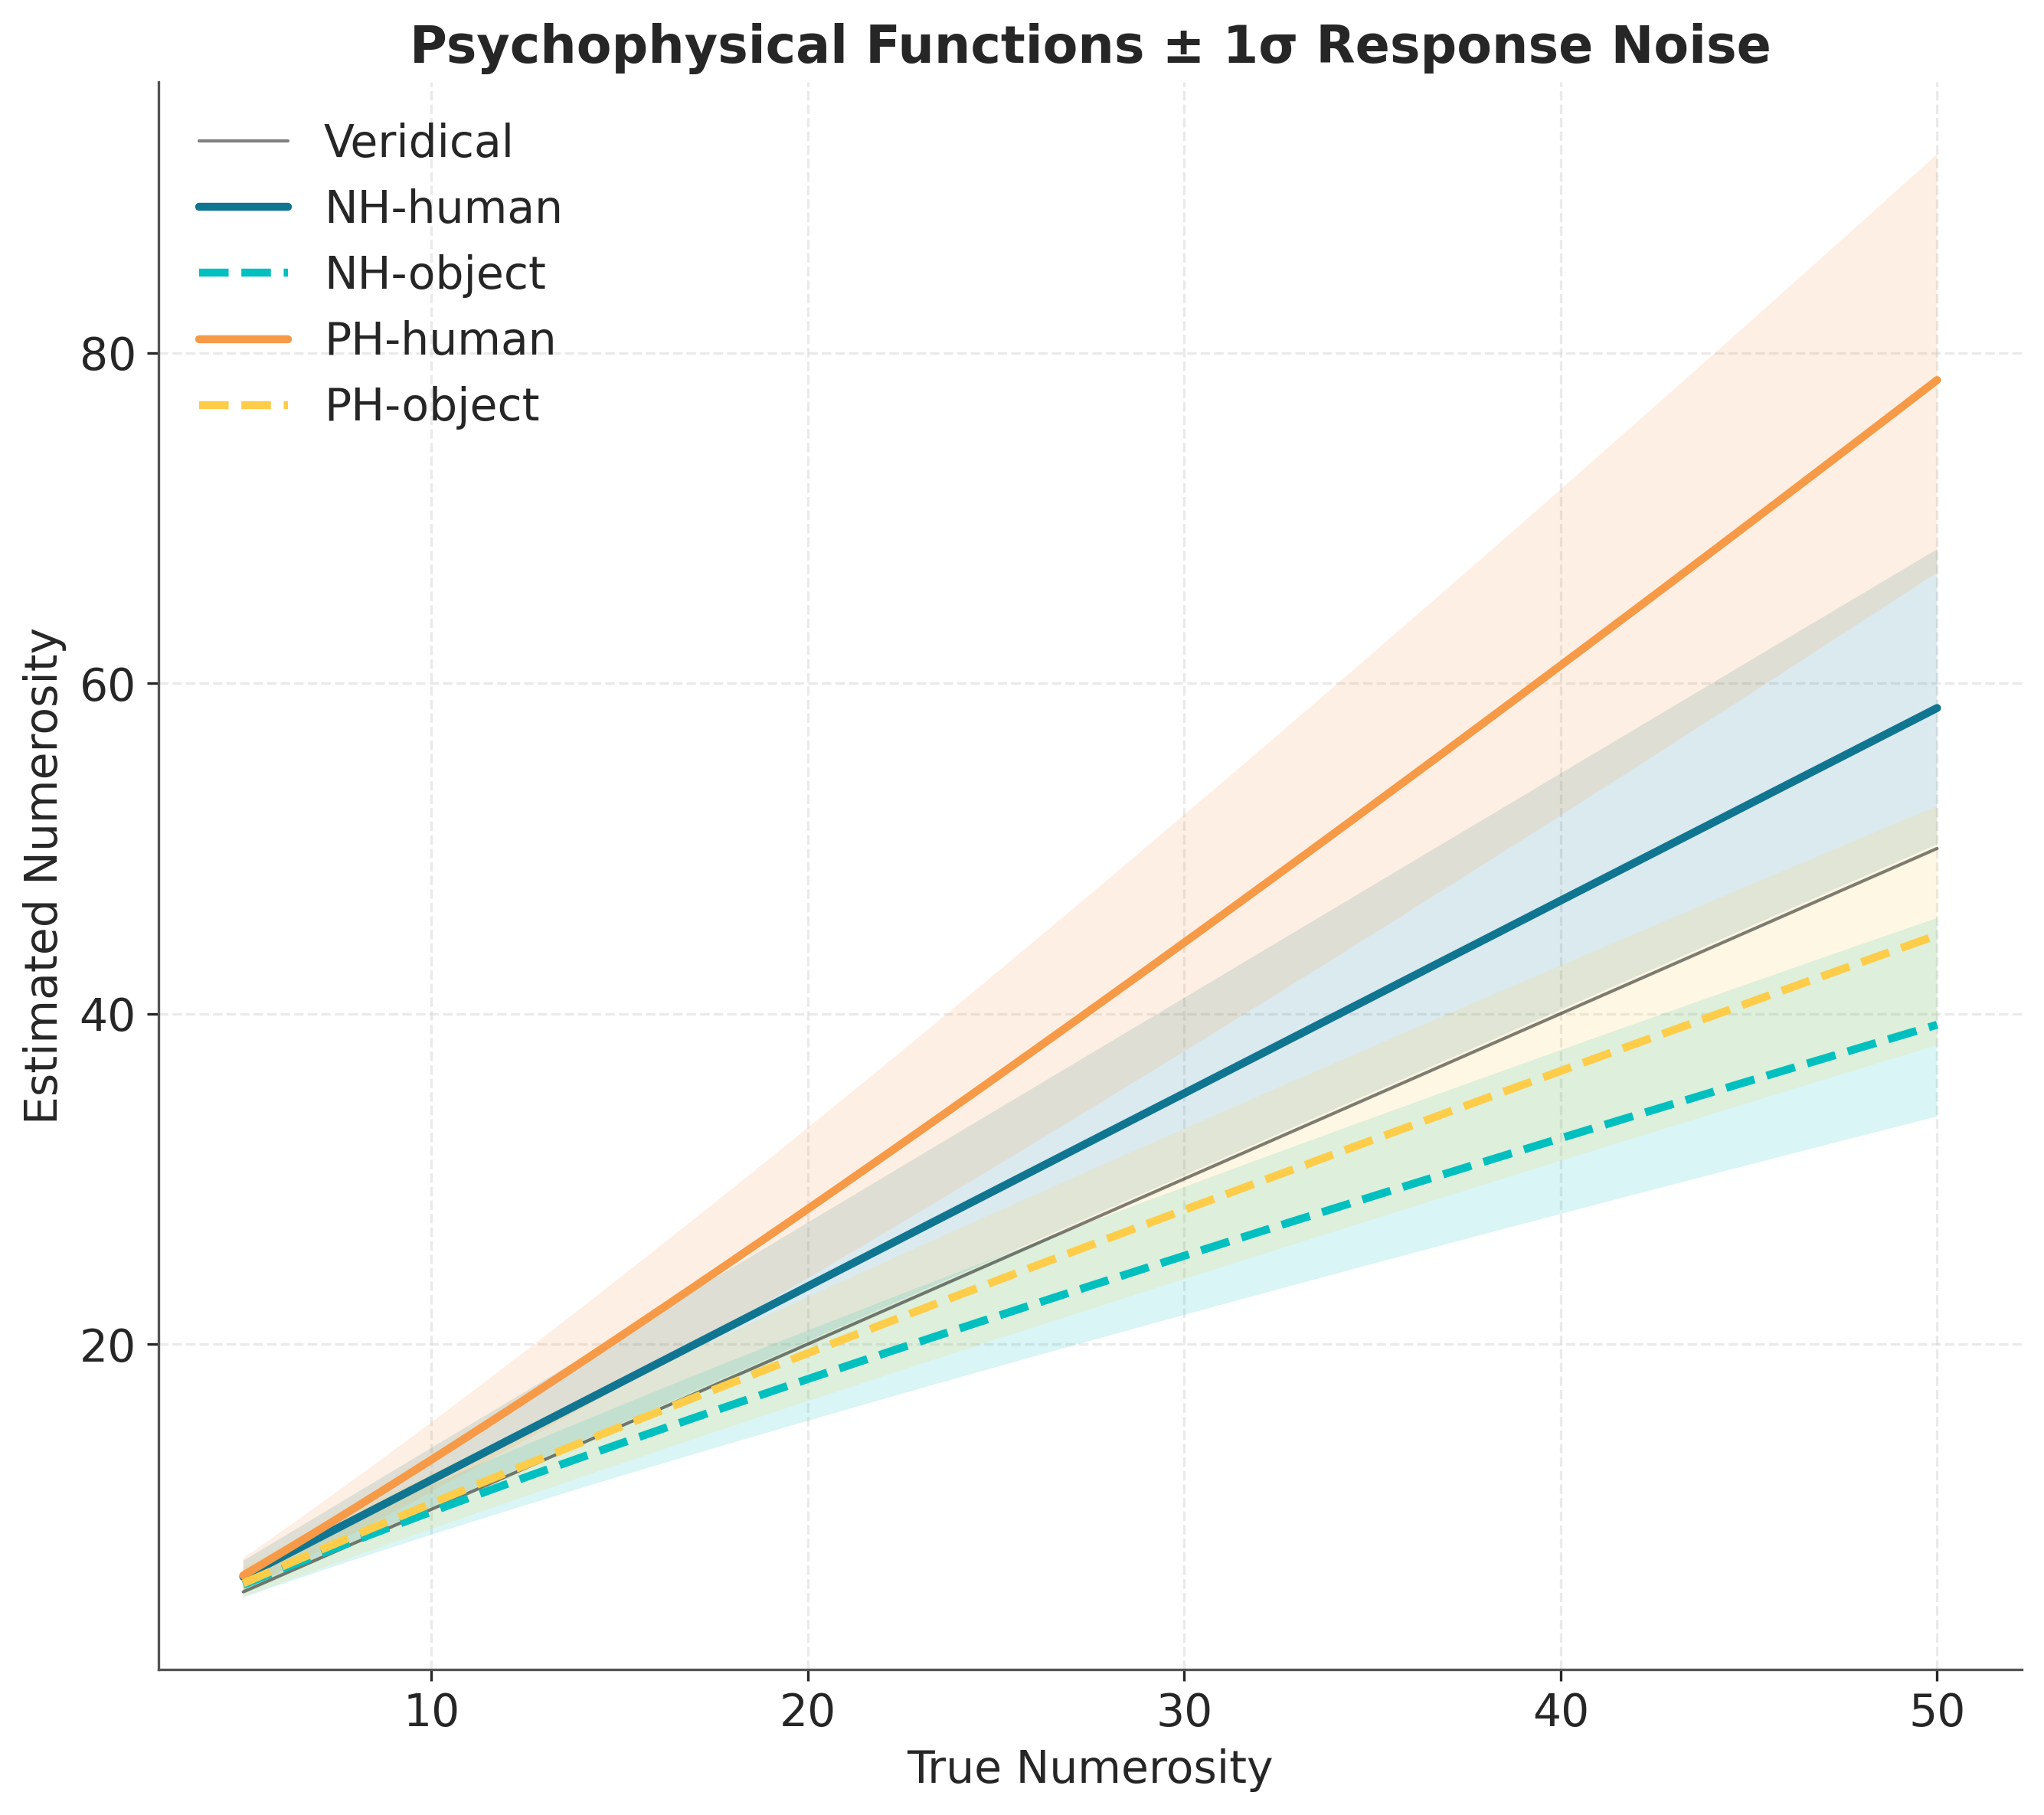

In [99]:
# ------------------------------------------------------------------
# 1. Curve Calculation
# ------------------------------------------------------------------
def get_prediction(n_range, log_alpha, beta):
    """
    Returns the median predicted response.
    y = exp(log_alpha) * n^beta
    """
    alpha = np.exp(log_alpha)
    return alpha * (n_range ** beta)

# ------------------------------------------------------------------
# 2. Plotting Function
# ------------------------------------------------------------------
def plot_psychophysics_with_sigma(idata, log_log_space=False):
    
    # --- A. Extract Means ---
    post = idata.posterior
    # Parameters defining the curve
    log_alpha_means = post["log_alpha_mu"].mean(dim=["chain", "draw"])
    beta_means = post["beta_mu"].mean(dim=["chain", "draw"])
    
    # Parameter defining the variance (NOISE)
    sigma_means = post["sigma_group"].mean(dim=["chain", "draw"])
    
    # --- B. Setup Range ---
    if log_log_space:
        n_range = np.geomspace(5, 50, 100)
    else:
        n_range = np.linspace(5, 50, 100)

    plt.figure(figsize=(9, 8))

    # --- Veridical reference ---
    plt.plot(n_range, n_range, "k-", linewidth=1, alpha=0.5, label="Veridical")

    # --- Setup Colors ---
    colors = {
        ("NH", "human"): "C0",
        ("NH", "object"): "C1",
        ("PH", "human"): "C2", 
        ("PH", "object"): "C3",
    }
    linestyles = {"human": "-", "object": "--"}

    # --- C. Plotting Loop ---
    groups = ["NH", "PH"]
    entities = ["human", "object"]

    for group in groups:
        # Get the noise level for this group
        # (The model assumes Sigma depends on Group, but not Entity)
        sigma_val = sigma_means.sel(group=group).item()
        
        for entity in entities:
            # Get curve parameters
            la_val = log_alpha_means.sel(group=group, entity_type=entity).item()
            b_val = beta_means.sel(group=group, entity_type=entity).item()

            # 1. Calculate the Median Curve
            y_pred = get_prediction(n_range, la_val, b_val)
            
            # 2. Calculate Variance Bounds (1 Standard Deviation)
            # Since model is LogNormal, +1 sigma in log space becomes * exp(sigma) in linear
            y_upper = y_pred * np.exp(sigma_val)
            y_lower = y_pred / np.exp(sigma_val)
            
            # 3. Plot the Line
            label = f"{group}-{entity}"
            plt.plot(
                n_range, 
                y_pred,
                color=colors[(group, entity)],
                linestyle=linestyles[entity],
                linewidth=2.5,
                label=label
            )
            
            # 4. Plot the Variance (Shaded Region)
            plt.fill_between(
                n_range,
                y_lower,
                y_upper,
                color=colors[(group, entity)],
                alpha=0.15, # Low opacity to see overlaps
                edgecolor=None
            )

    # --- Formatting ---
    if log_log_space:
        plt.xscale("log")
        plt.yscale("log")
        from matplotlib.ticker import ScalarFormatter
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
        plt.xlabel("True Numerosity (Log Scale)")
        plt.ylabel("Estimated Numerosity (Log Scale)")
    else:
        plt.xlabel("True Numerosity")
        plt.ylabel("Estimated Numerosity")

    plt.title("Psychophysical Functions ± 1σ Response Noise")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Run
plot_psychophysics_with_sigma(idata=idata, log_log_space=False)

Aggregated posteriors

Detected entity labels: ['object' 'human']


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_64249/2162943997.py:94: UserWarning:

The figure layout has changed to tight



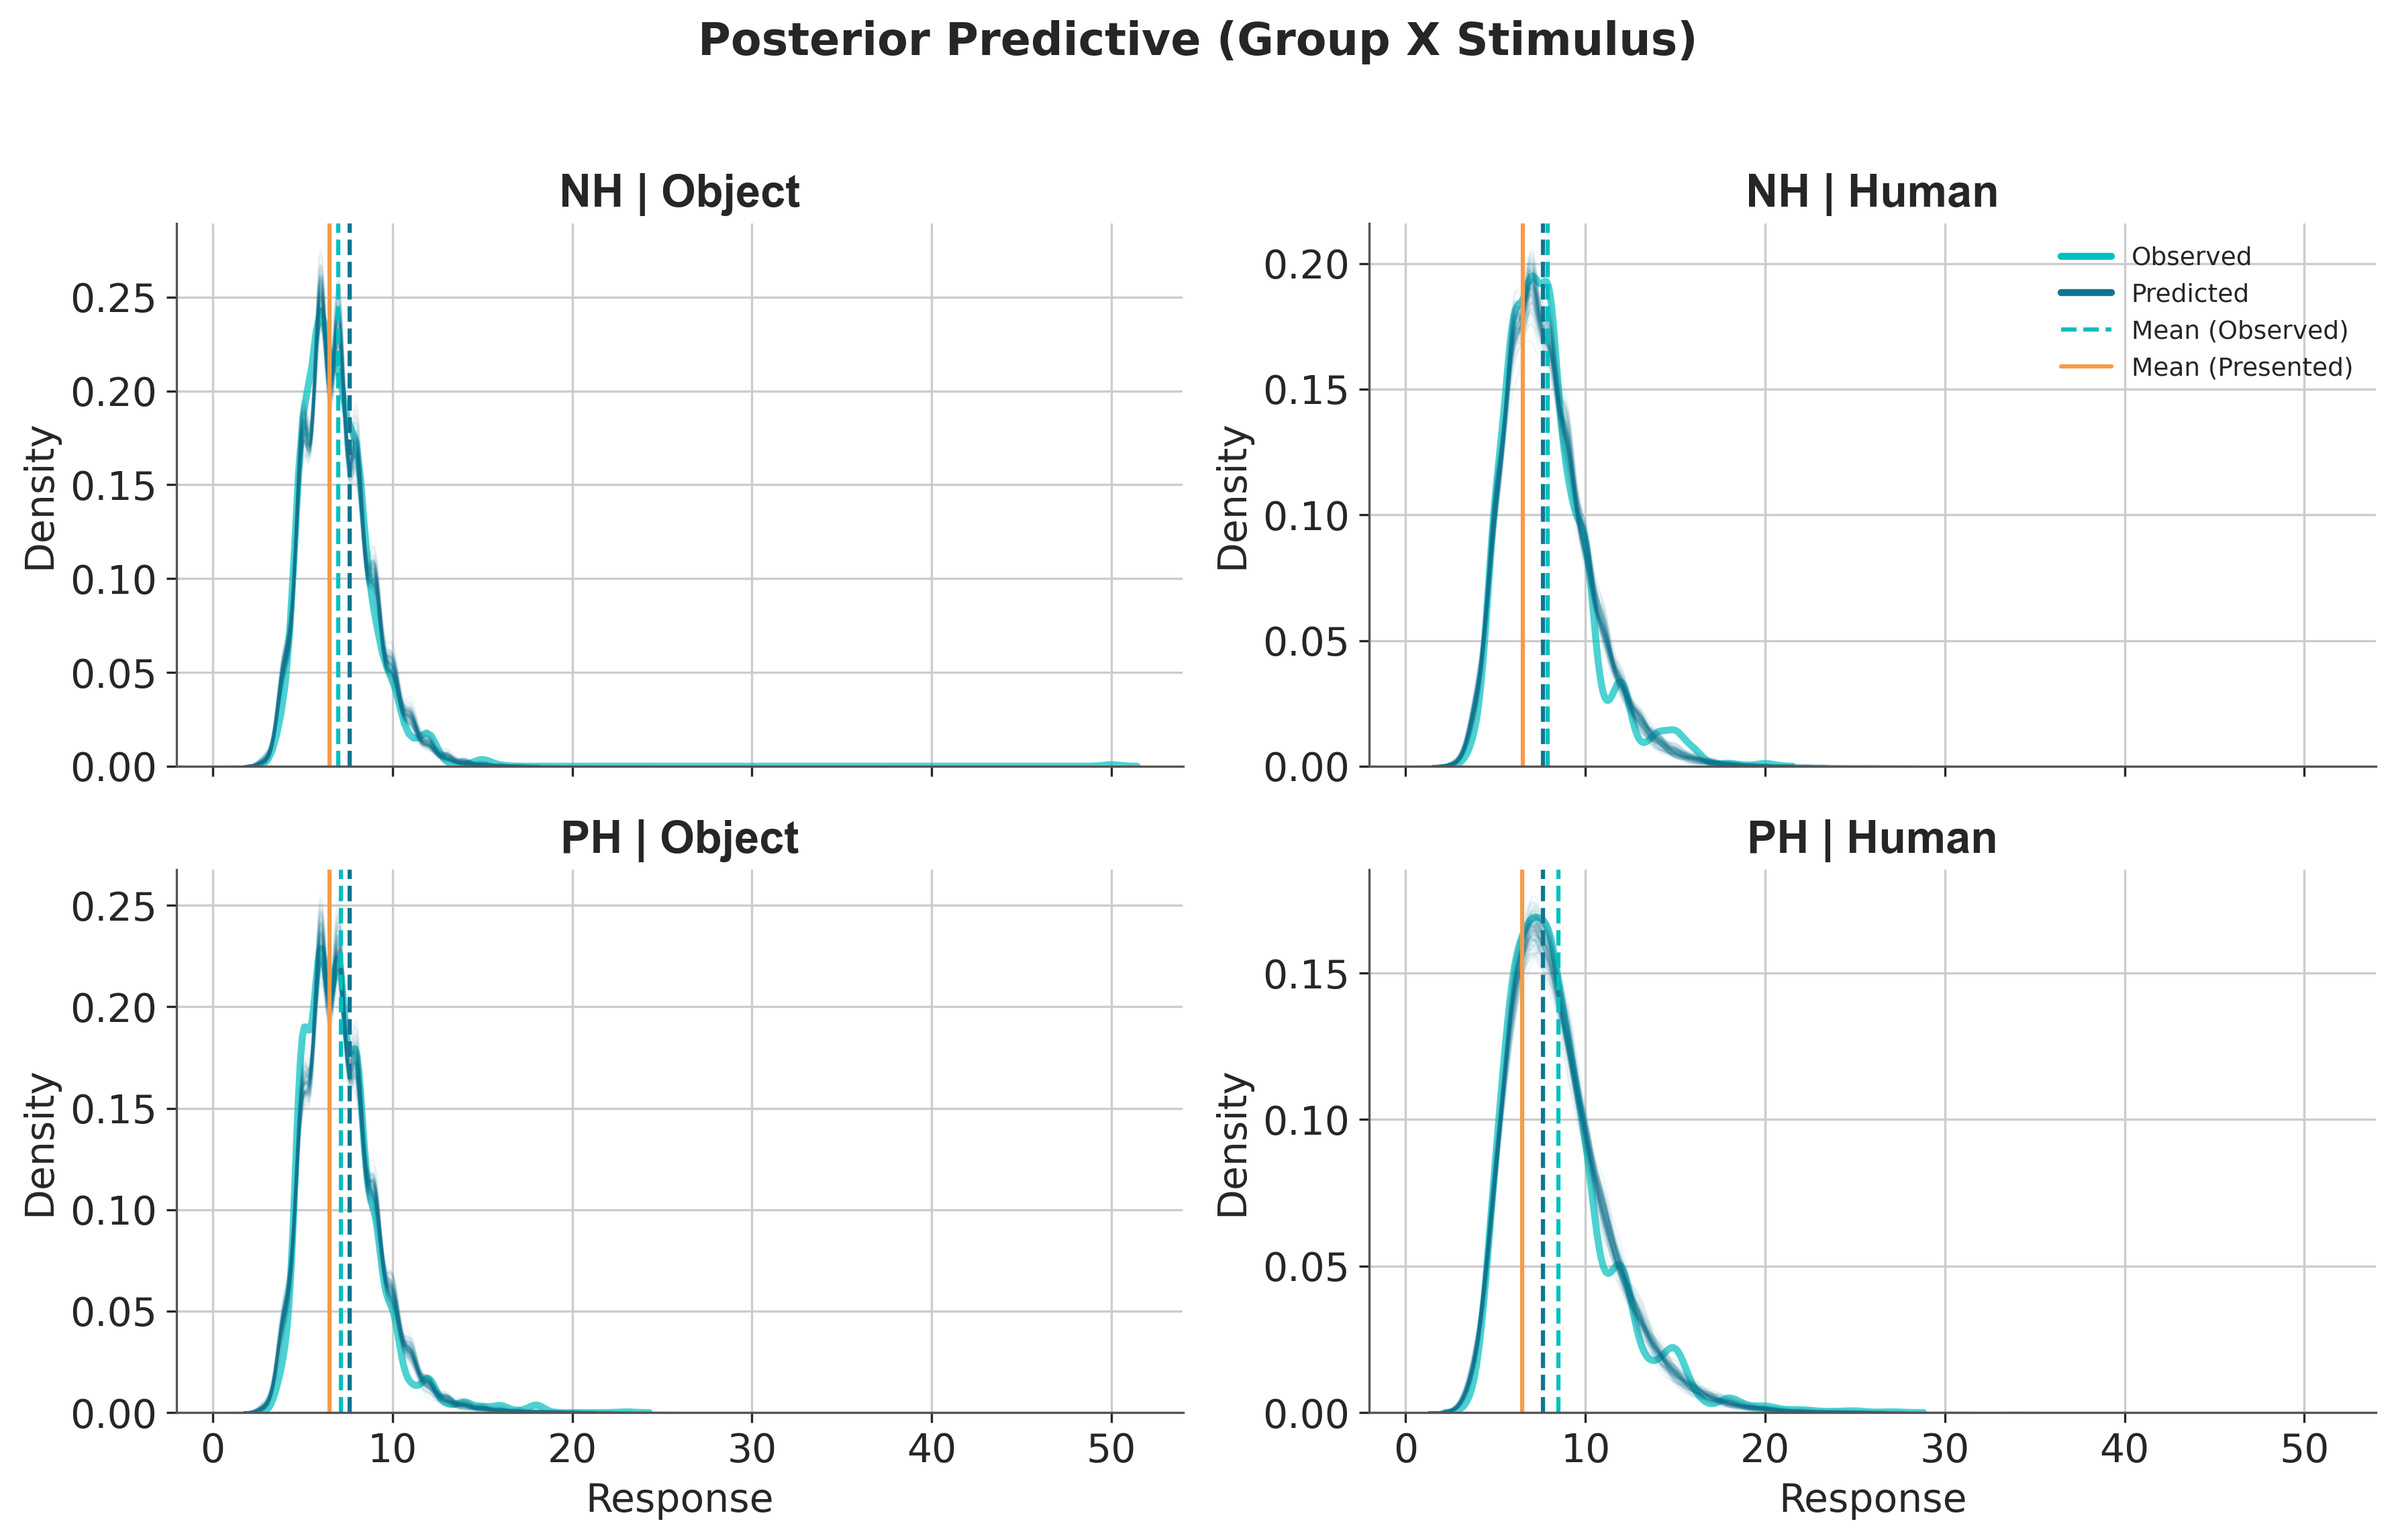

In [ ]:
from matplotlib.lines import Line2D

# --- 1. PREPARE MAPPING ---
unique_entities = X["entity"].unique()
print(f"Detected entity labels: {unique_entities}")

if "human" in unique_entities or "Human" in unique_entities:
    entity_map = {
        0: "object",  # adjust casing if needed
        1: "human"
    }
else:
    entity_map = {0: 0, 1: 1}

# Extract posterior predictive samples (keep full shape)
y_pred_all = idata.posterior_predictive.y_pred.values  # shape: (n_chains, n_draws, n_trials)
n_chains, n_draws, n_trials = y_pred_all.shape

# Optionally subsample draws for speed/clarity (e.g., 100 draws total)
n_subsample = 100
rng = np.random.default_rng(42)
draw_indices = rng.choice(n_chains * n_draws, size=n_subsample, replace=False)
y_pred_subsample = y_pred_all.reshape(n_chains * n_draws, n_trials)[draw_indices]  # (n_subsample, n_trials)

# Ensure groups are sorted consistently
groups = sorted(X["s_param_ph"].unique())
group_labels = ["NH", "PH"]

# --- 2. PLOT ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
fig.suptitle("Posterior Predictive (Group X Stimulus)", fontsize=16)

color_pred = "C0"  # Blue (for predicted)
color_obs = "C1"   # Orange (for observed)
color_true = "C2"  # For presented numerosity mean

for i, group in enumerate(groups):
    for j, ent_int in enumerate([0, 1]):
        ax = axes[i, j]
        
        df_ent_value = entity_map[ent_int]
        mask = (X["s_param_ph"] == group) & (X["entity"] == df_ent_value)
        
        if mask.sum() == 0:
            ax.text(0.5, 0.5, f"NO DATA\nGroup: {group_labels[i]}\nEntity: {df_ent_value}", 
                    ha='center', va='center', color='red')
            continue
            
        # Observed responses
        obs_subset = y_obs[mask] if isinstance(y_obs, np.ndarray) else y_obs.values[mask]
        
        # Presented numerosity (assumed to be in X)
        presented_num = X.loc[mask, "Presented_numerosity"]
        mean_presented = presented_num.mean()

        # Plot observed KDE
        sns.kdeplot(
            obs_subset, 
            color=color_obs,
            linewidth=2.5, 
            alpha=0.7,
            label="Observed", 
            ax=ax
        )
        
        # Plot each posterior predictive draw as a separate KDE (faint lines)
        for draw in y_pred_subsample[:, mask]:
            sns.kdeplot(
                draw,
                color=color_pred,
                alpha=0.05,          # very transparent
                linewidth=0.8,
                ax=ax
            )
        
        # Add mean lines
        ax.axvline(np.mean(y_pred_subsample[:, mask]), color=color_pred, linestyle="--", linewidth=1.5, label="Mean (Predicted)")
        ax.axvline(np.mean(obs_subset), color=color_obs, linestyle="--", linewidth=1.5, label="Mean (Observed)")
        ax.axvline(mean_presented, color=color_true, linestyle="-", linewidth=1.5, label="Mean (Presented)")

        # Labels
        ent_label = "Human" if ent_int == 1 else "Object"
        ax.set_title(f"{group_labels[i]} | {ent_label}", fontdict=dict(family="Arial"))
        ax.set_xlabel("Response")

# Only add legend once (top-left)
legend_elements = [
    Line2D([0], [0], color=color_obs, lw=2.5, label='Observed'),
    Line2D([0], [0], color=color_pred, lw=2.5, label='Predicted'),  # representative predicted line
    Line2D([0], [0], color=color_obs, lw=1.5, ls='--', label='Mean (Observed)'),
    Line2D([0], [0], color=color_true, lw=1.5, ls='-', label='Mean (Presented)')
]
axes[0, 1].legend(handles=legend_elements, fontsize=9)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig(plot_dir/"ppc_group.png")

## Entity-Specific Effects

In [ ]:
az.plot_forest(
    idata,
    var_names=["alpha_group_mu", "beta_group_mu", "delta_alpha_group_entity", "delta_beta_group_entity", "sigma_0_group", "sigma_1_group"],
    combined=True,
    hdi_prob=0.95
)

# Subject level parameters